In [2]:
import pandas as pd
file_path = '/Users/chris/Desktop/processed_data.csv'
df = pd.read_csv(file_path)
import statsmodels.api as sm

# Identify columns that are country dummy columns (those with boolean True/False values)
country_columns = [col for col in df.columns if col.startswith('country_')]

# Convert True/False to 1/0 for country columns
df[country_columns] = df[country_columns].astype(int)


/var/folders/k5/_b8m4_y91ndf37bvq9_1p8pm0000gn/T/ipykernel_67623/3422264998.py:3: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


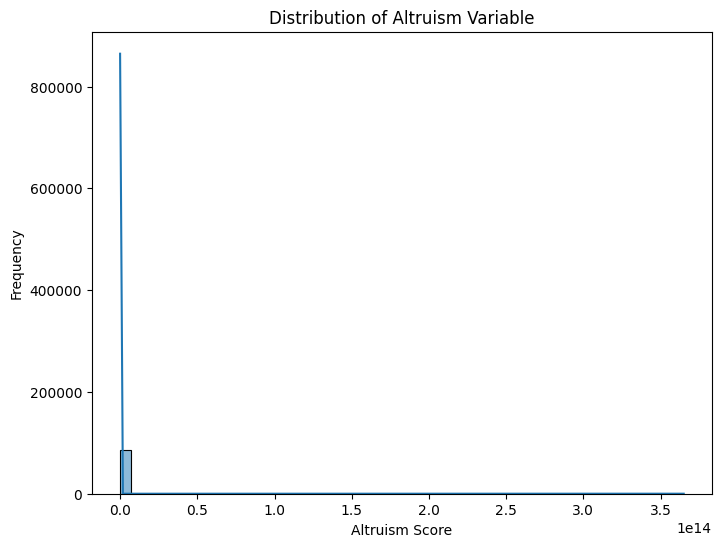

Altruism Variable Summary Statistics:
count    8.553200e+04
mean     2.604338e+10
std      2.792517e+12
min     -2.610568e+00
25%     -6.069670e-01
50%      1.593132e-01
75%      7.940759e-01
max      3.649952e+14
Name: altruism, dtype: float64

Top 5 Highest Altruism Values:
1961    3.649952e+14
2430    3.649952e+14
5152    3.649952e+14
5216    3.649952e+14
1747    1.826803e+14
Name: altruism, dtype: float64

Bottom 5 Lowest Altruism Values:
6028   -2.610568
6201   -2.610568
6894   -2.610568
6898   -2.610568
6985   -2.610568
Name: altruism, dtype: float64


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['altruism'].dropna(), bins=50, kde=True)
plt.title('Distribution of Altruism Variable')
plt.xlabel('Altruism Score')
plt.ylabel('Frequency')
plt.show()

# Check basic statistics
print("Altruism Variable Summary Statistics:")
print(df['altruism'].describe())

# Check for extreme values
print("\nTop 5 Highest Altruism Values:")
print(df['altruism'].nlargest(5))

print("\nBottom 5 Lowest Altruism Values:")
print(df['altruism'].nsmallest(5))

# Define a reasonable maximum value based on domain knowledge
max_reasonable_value = 10  # Example value

# Cap values
df['altruism_capped'] = df['altruism'].clip(upper=max_reasonable_value)
df['altruism'] = df['altruism_capped']  # or df['altruism_capped']

Data types before conversion:
participant_id           object
age                     float64
gender                    int64
Donate                  float64
Personal_retribution    float64
                         ...   
country_Venezuela         int64
country_Vietnam           int64
country_Zimbabwe          int64
category_binary           int64
altruism_capped         float64
Length: 106, dtype: object

Data types after conversion:
participant_id           object
age                     float64
gender                    int64
Donate                  float64
Personal_retribution    float64
                         ...   
country_Venezuela         int64
country_Vietnam           int64
country_Zimbabwe          int64
category_binary           int64
altruism_capped         float64
Length: 106, dtype: object

Missing values per column:
participant_id          79633
age                        32
gender                      0
Donate                  79633
Personal_retribution    79634
    

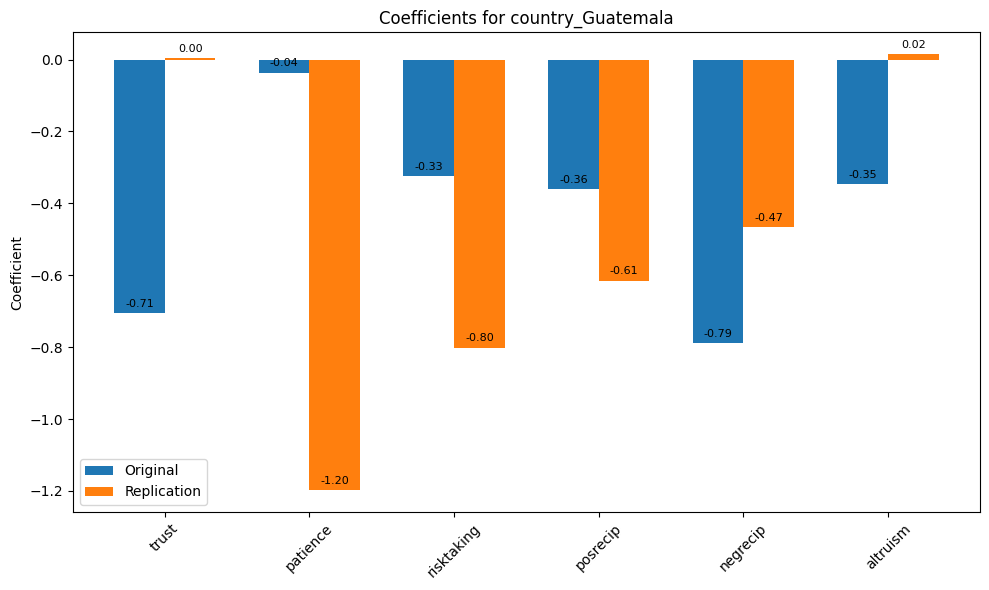

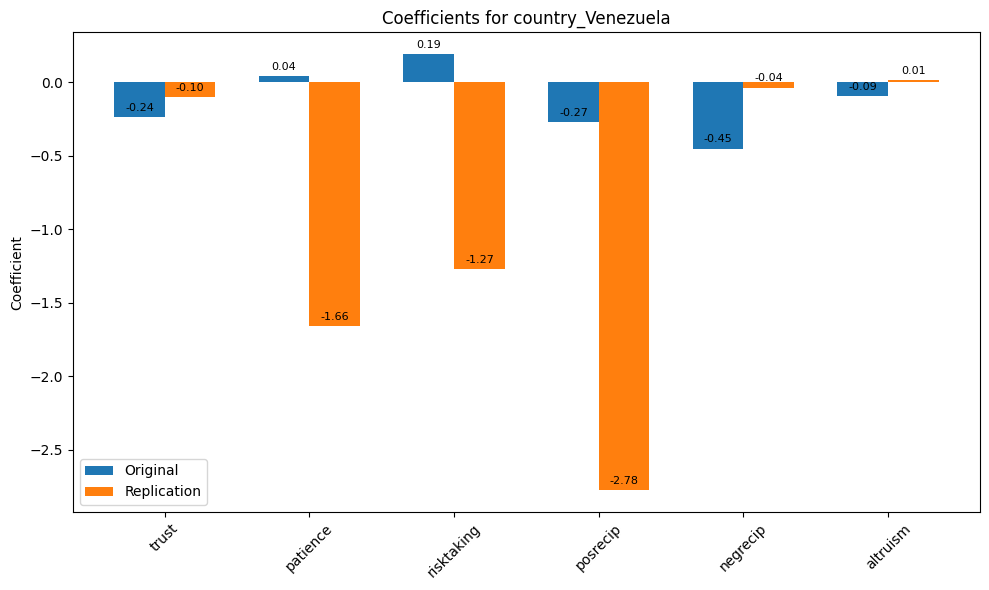

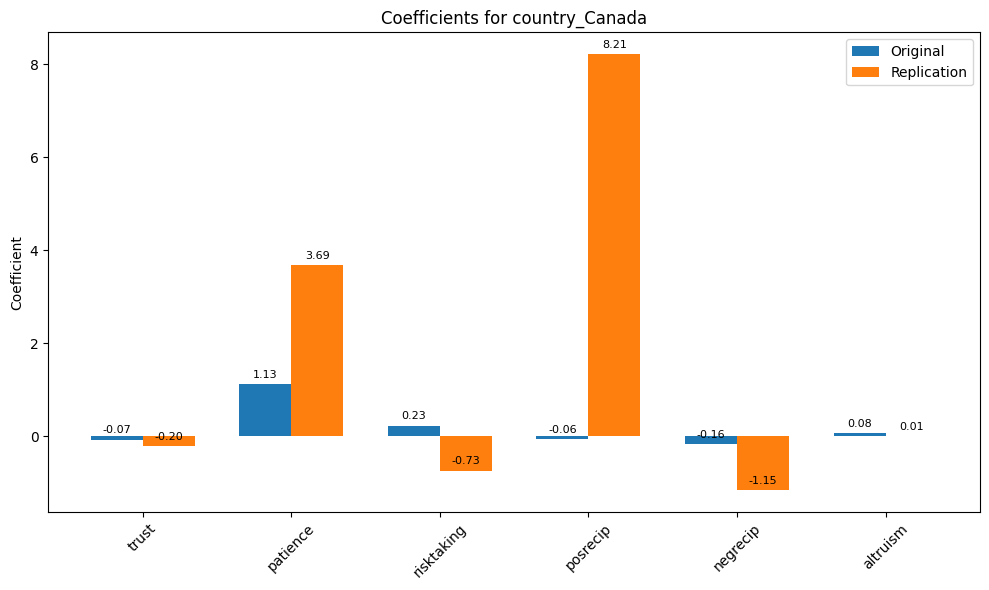

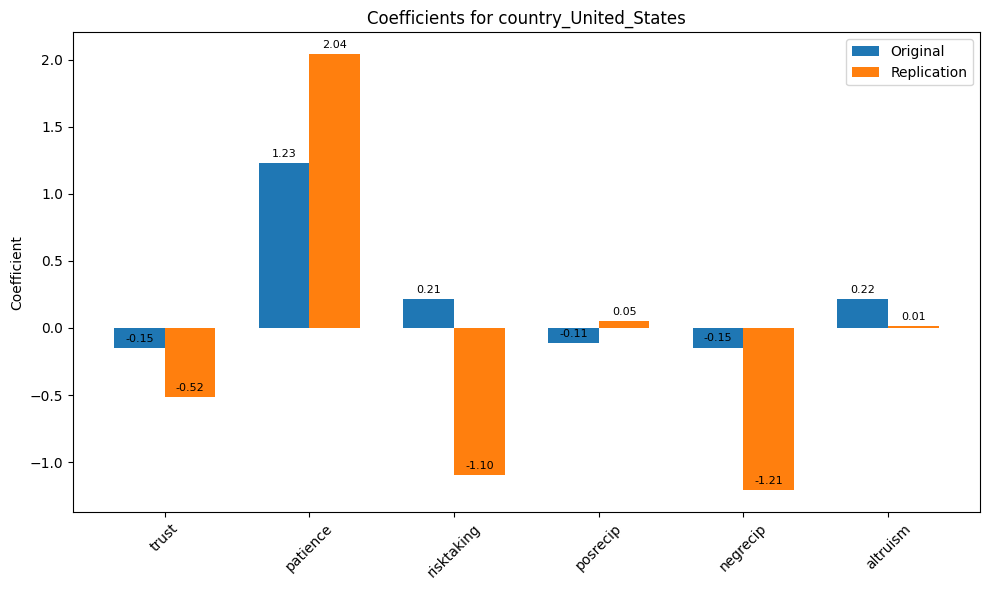

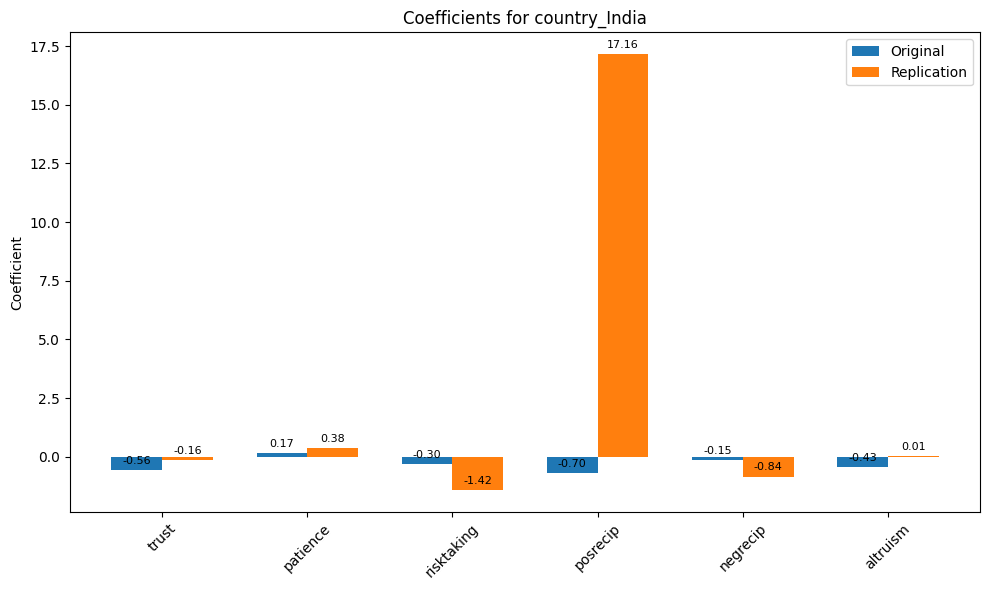

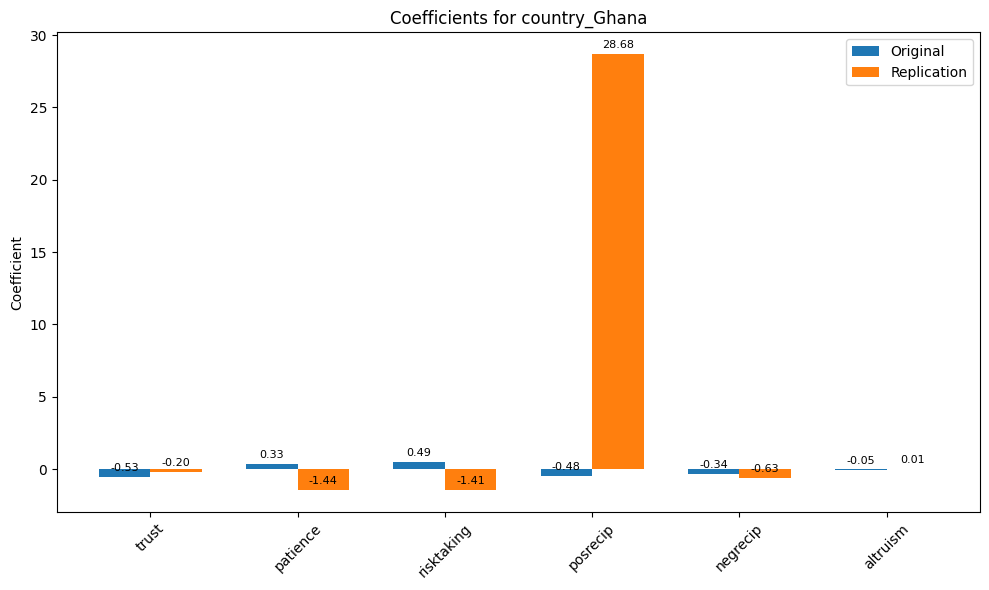

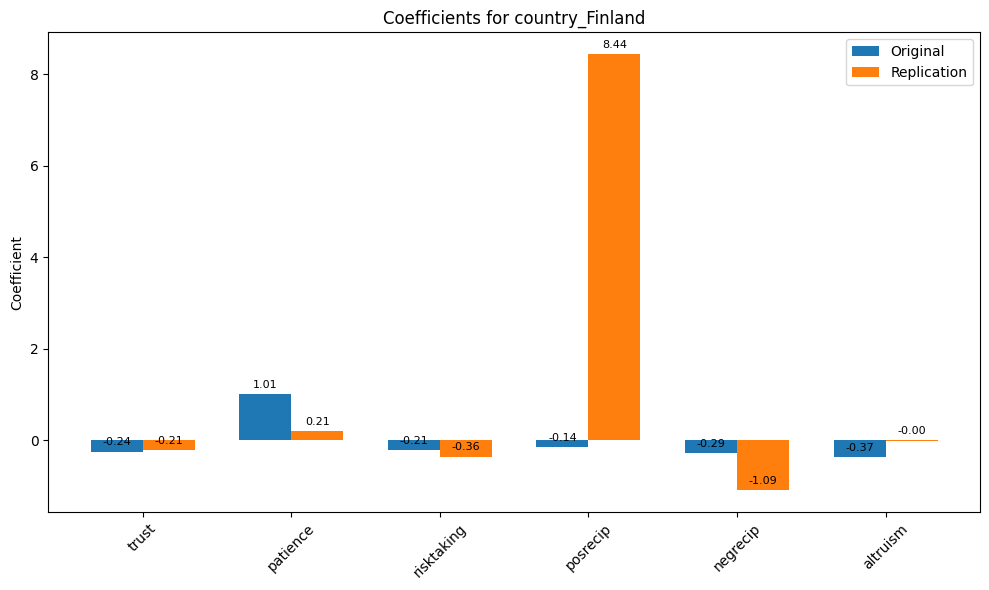

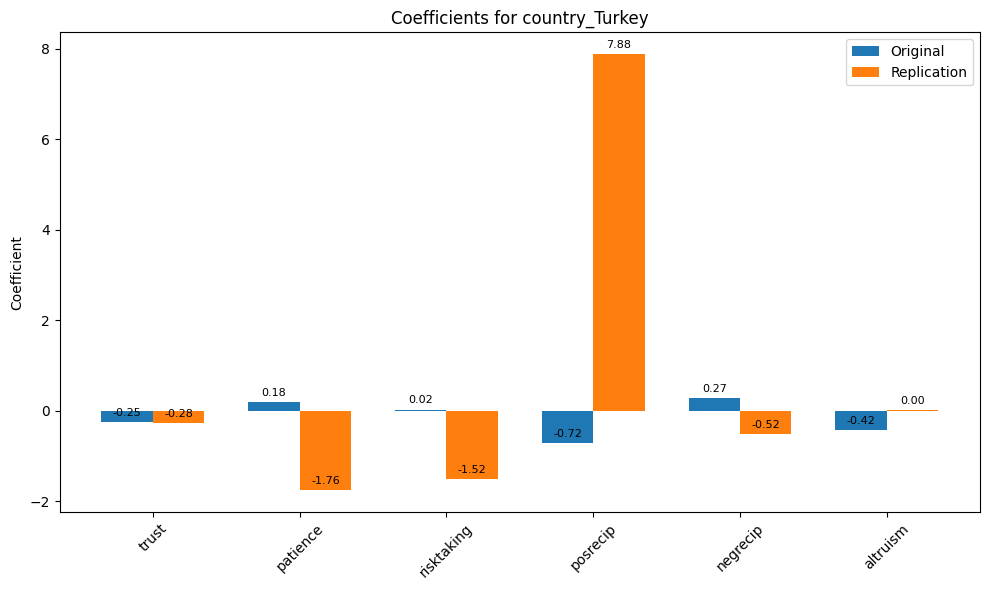

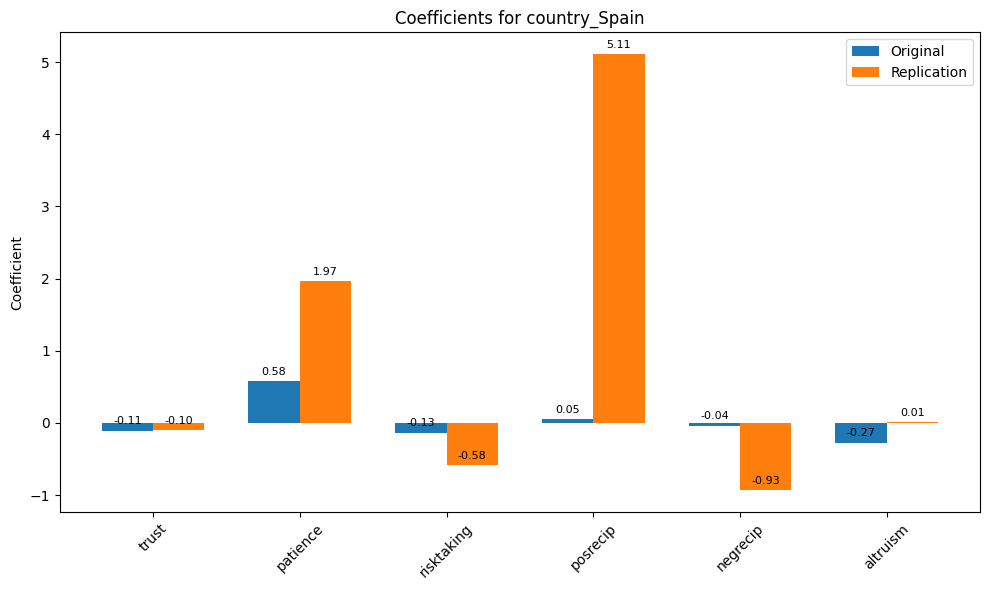

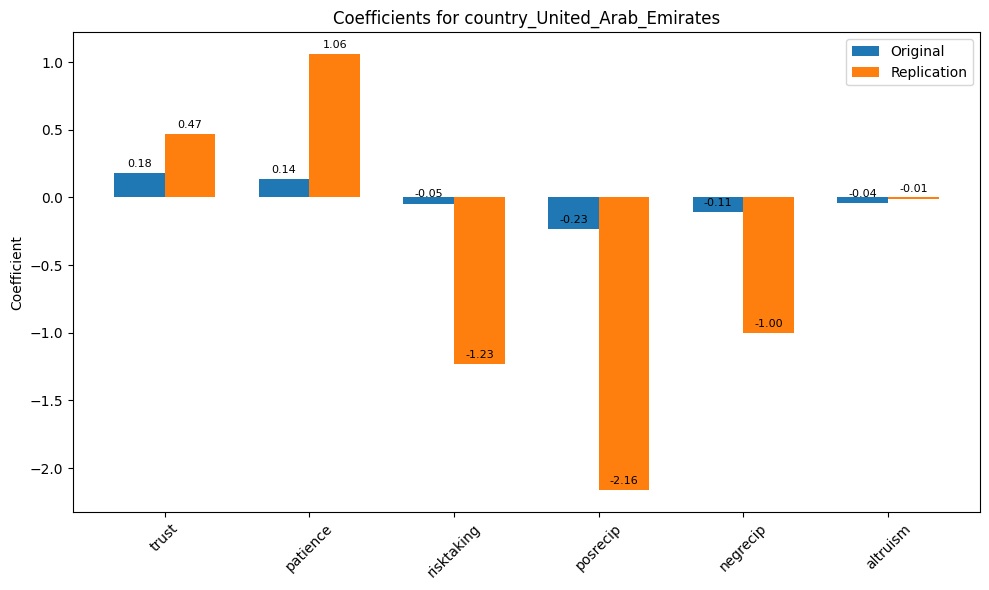

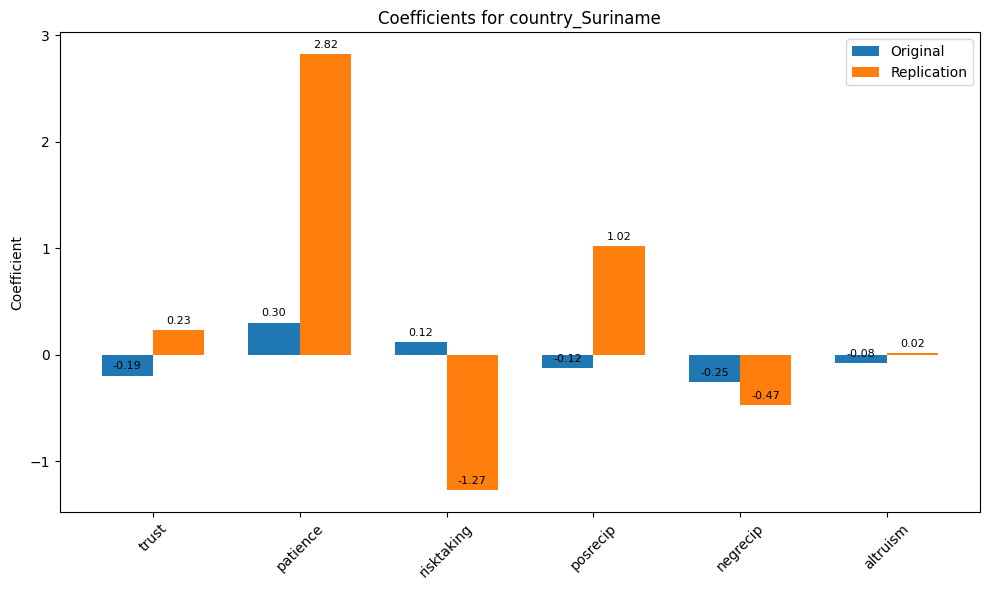

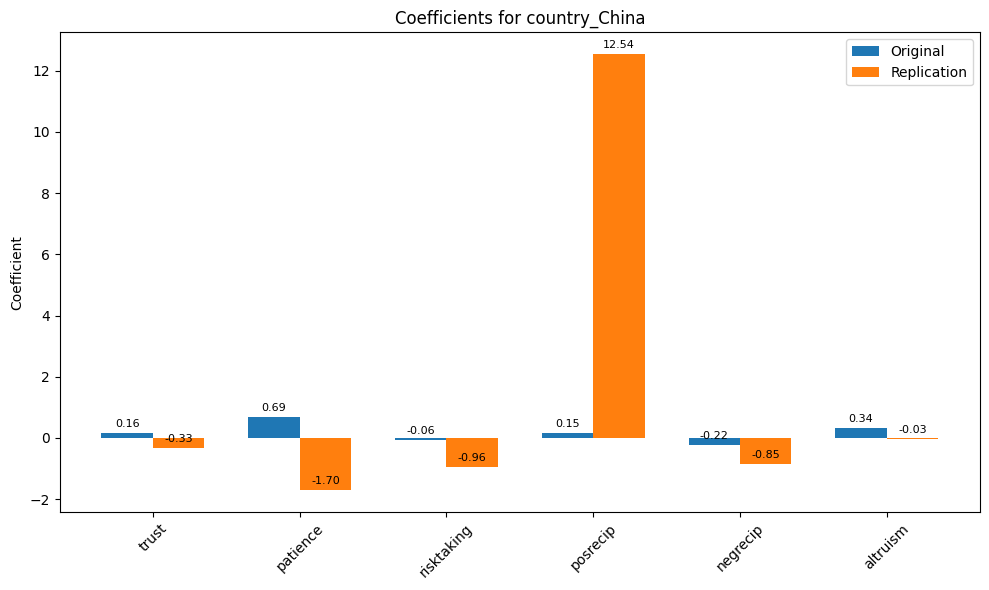

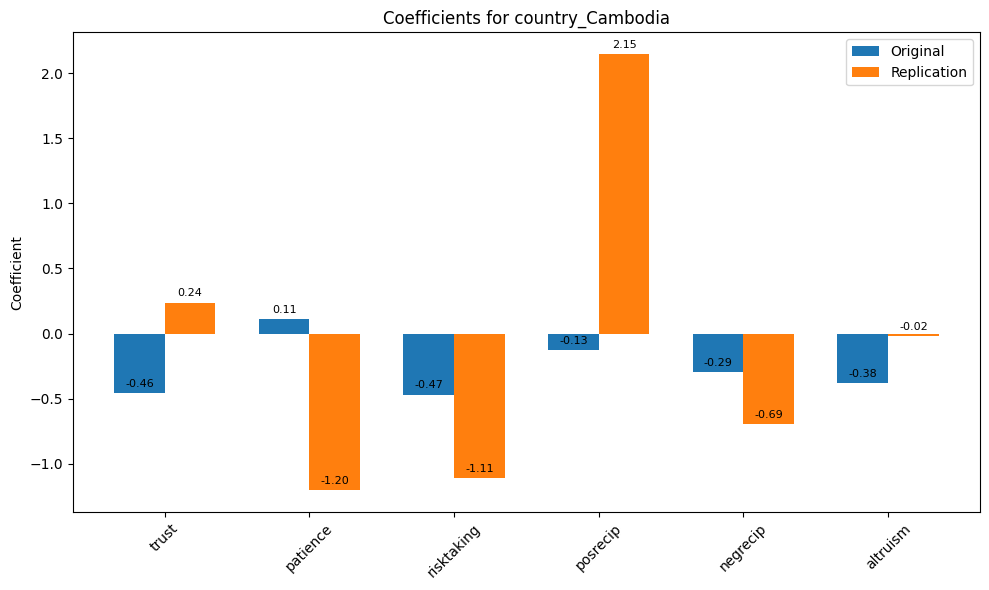

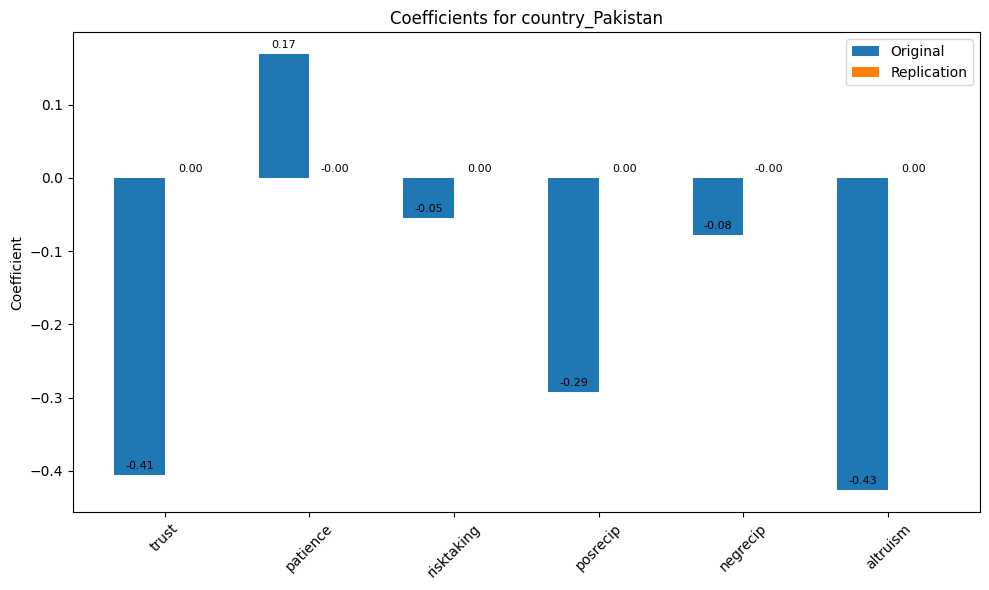

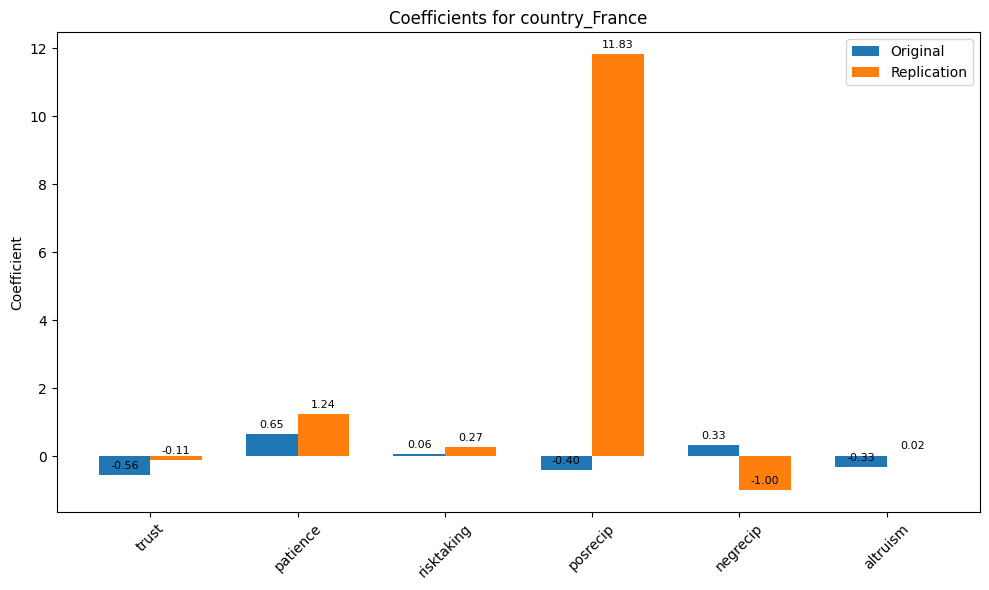

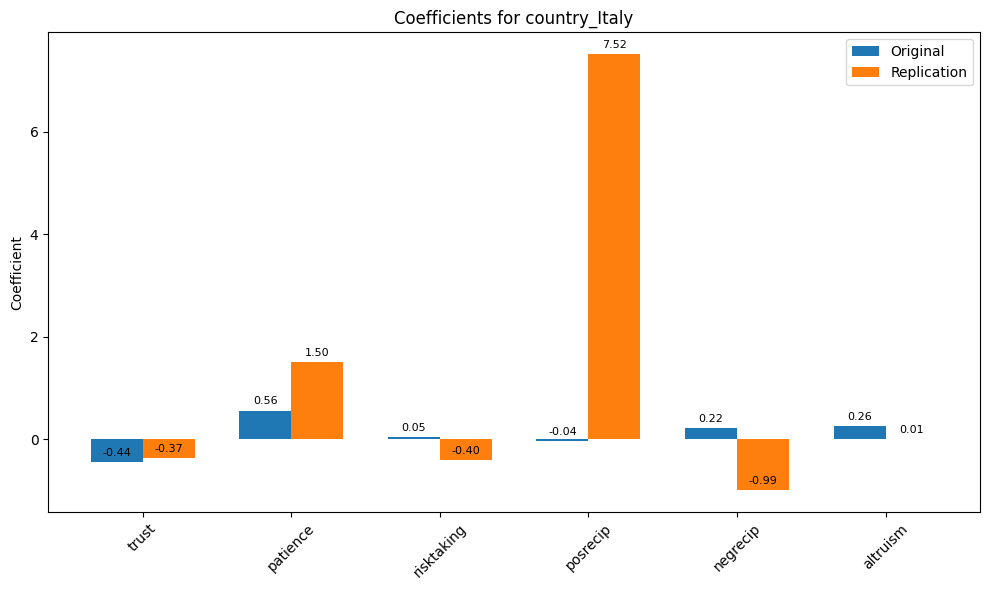

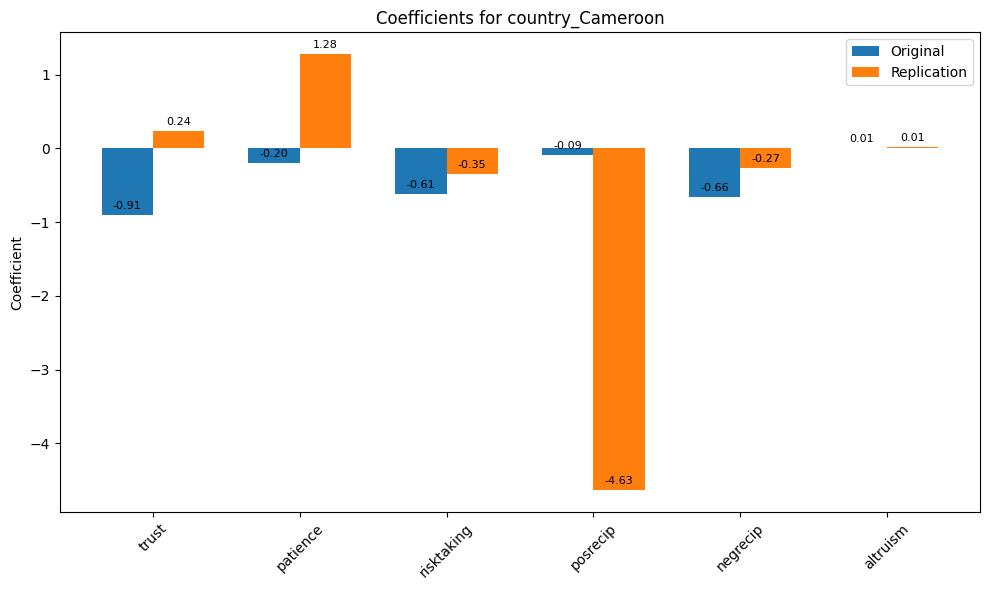

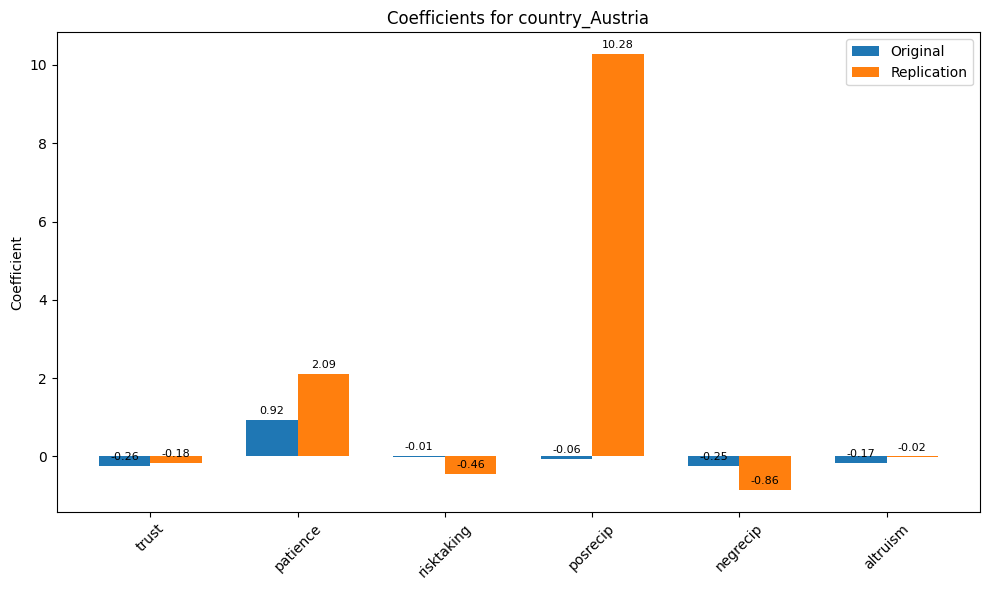

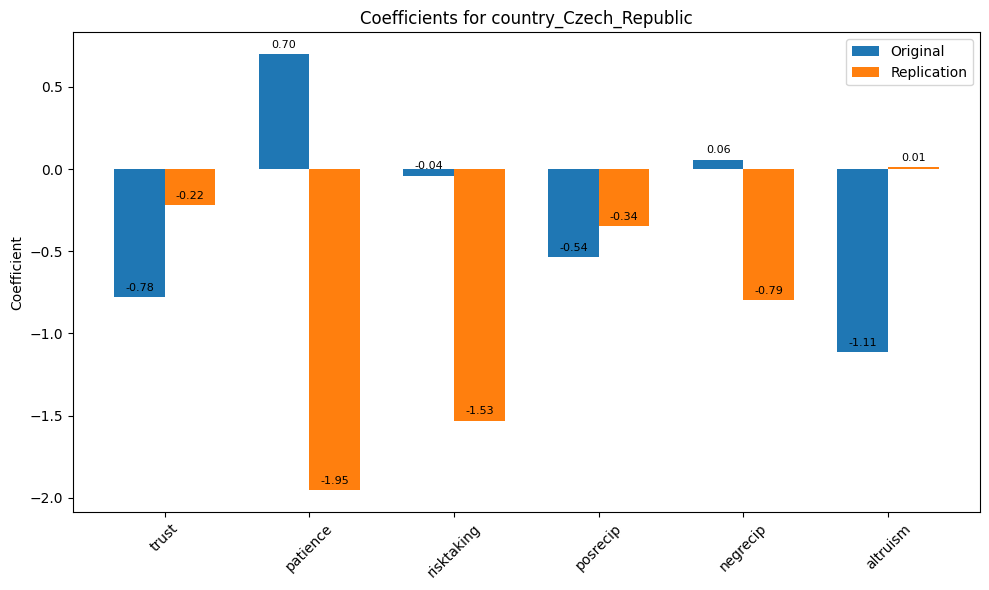

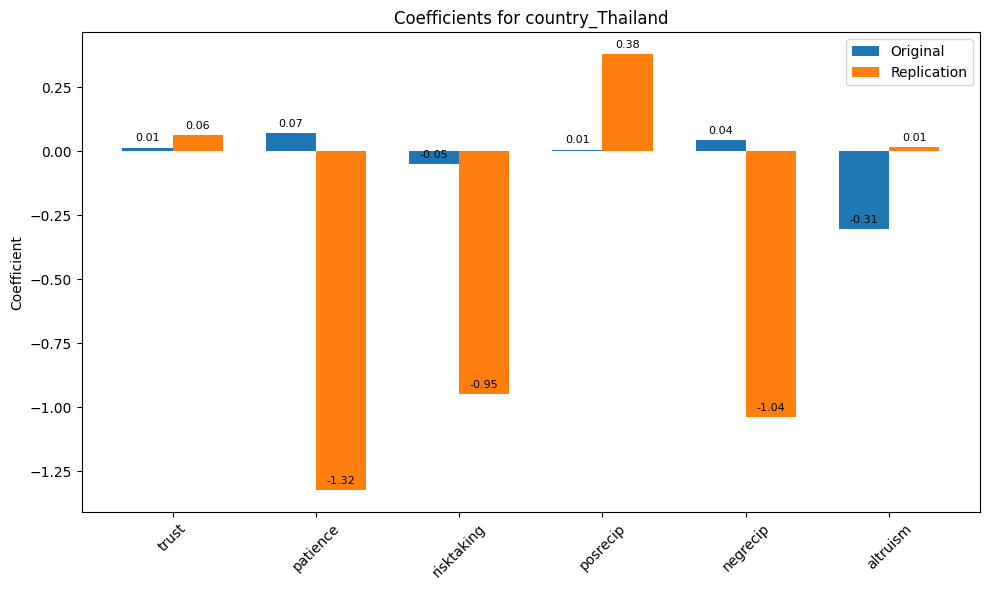

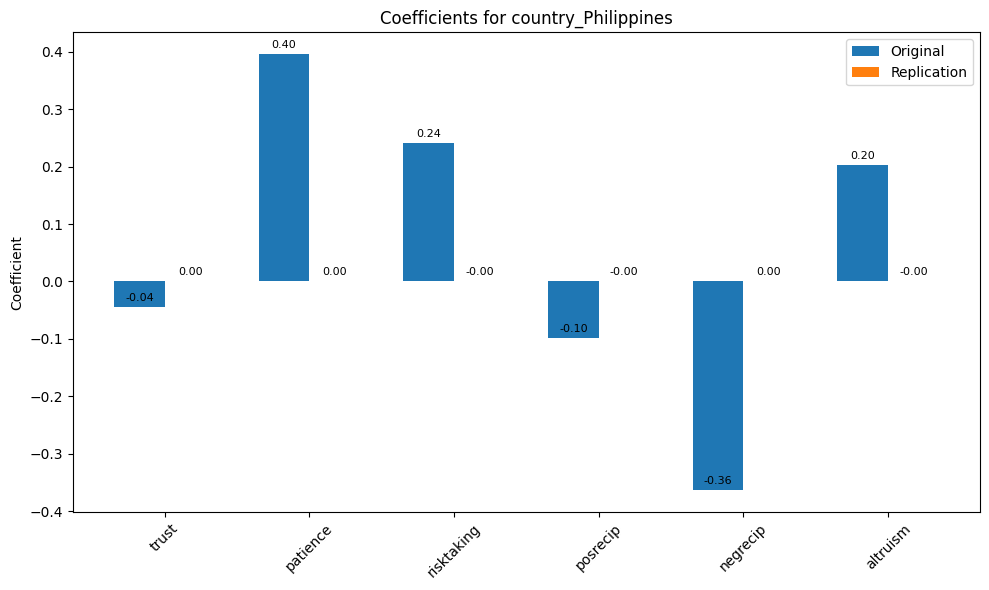

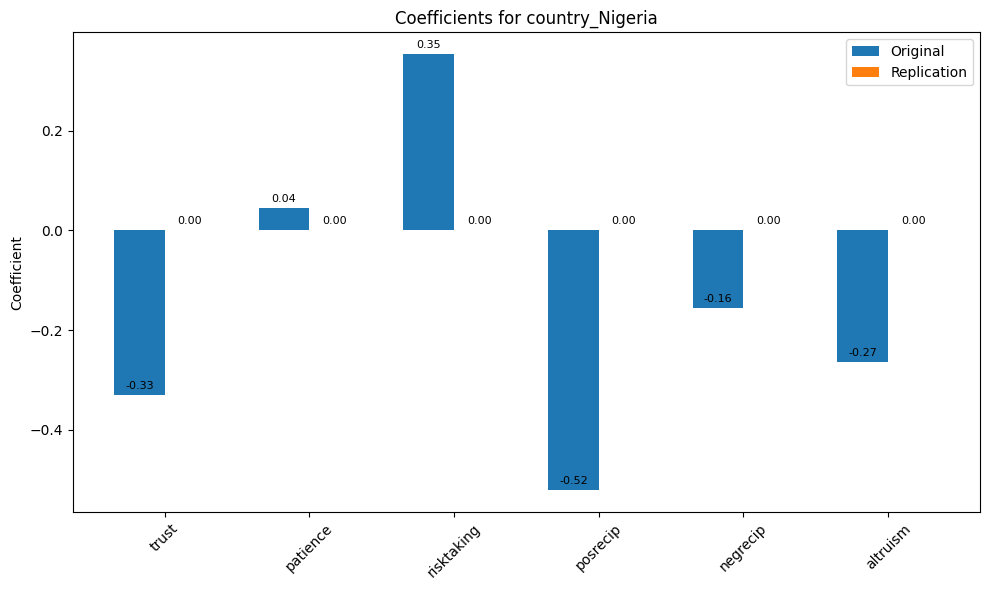

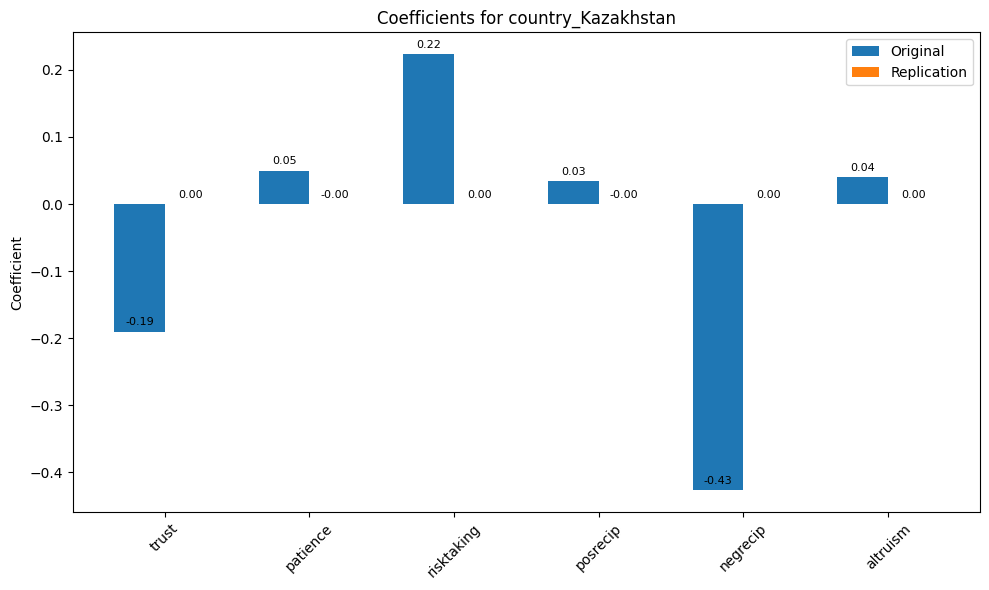

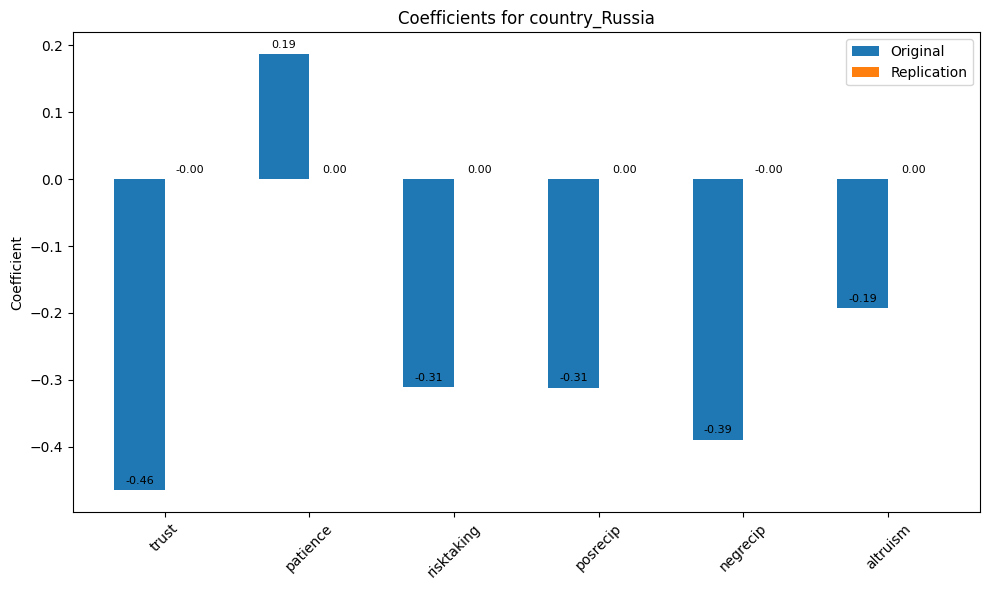

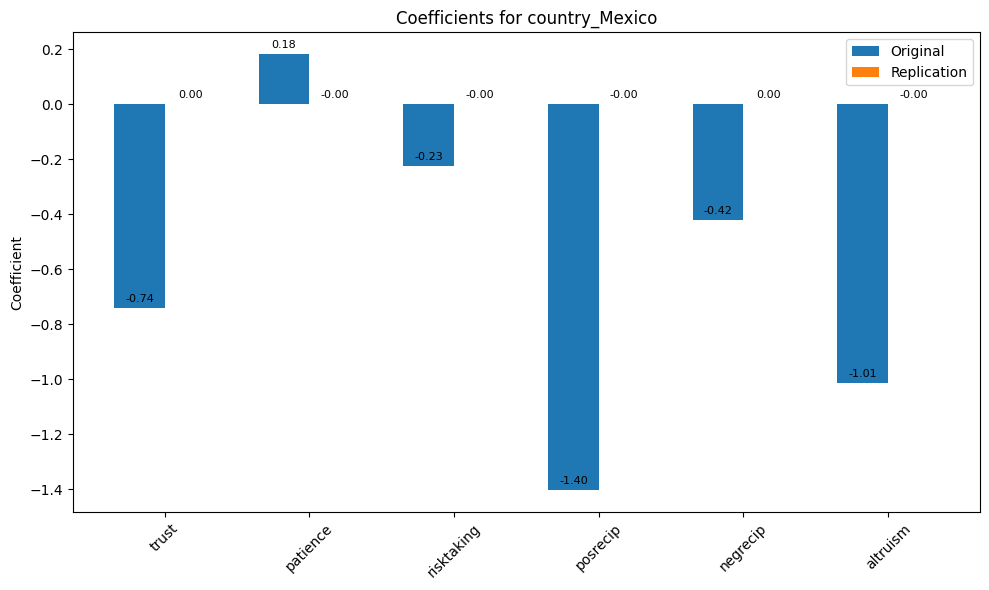

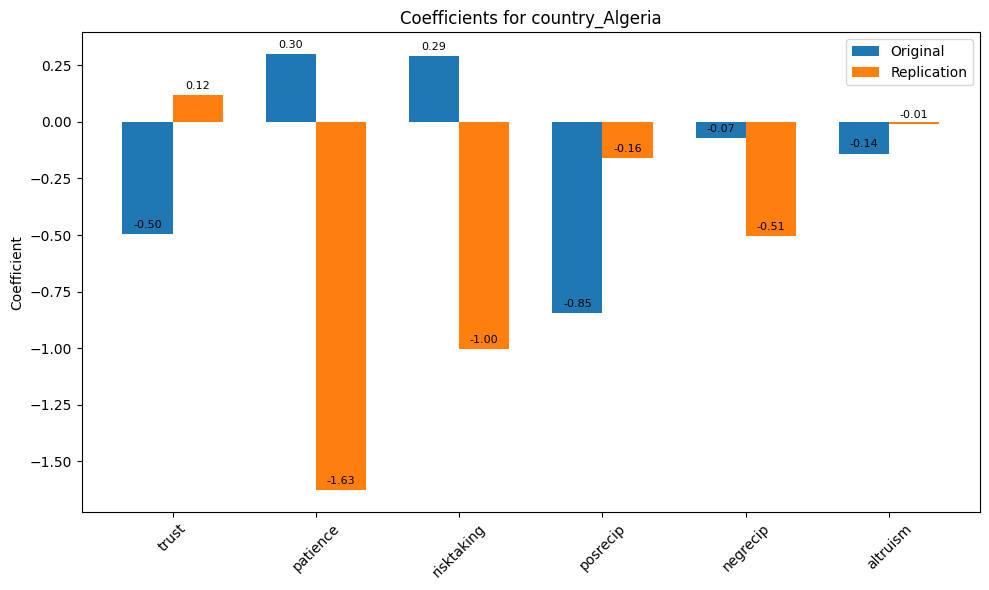

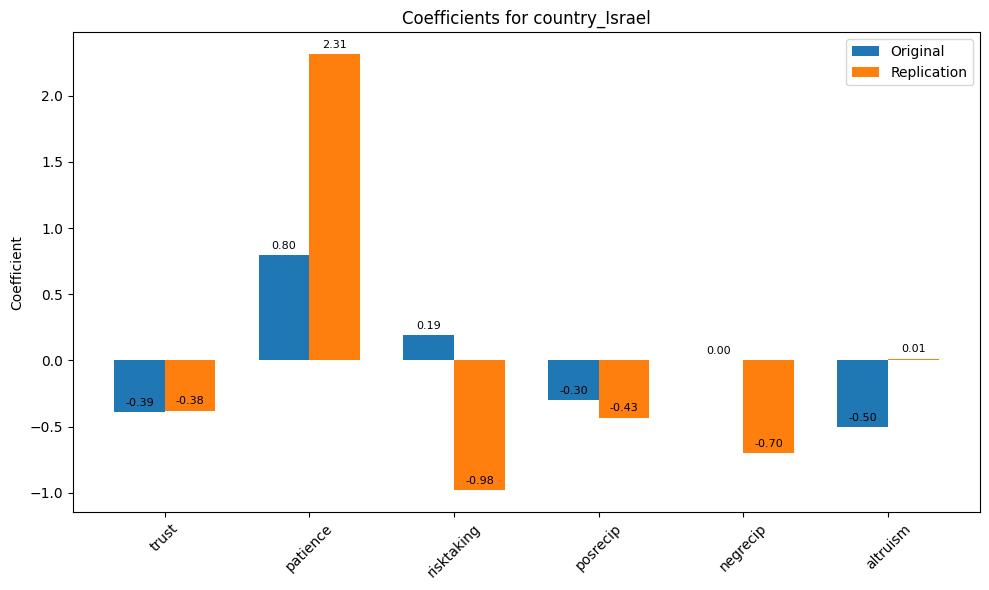

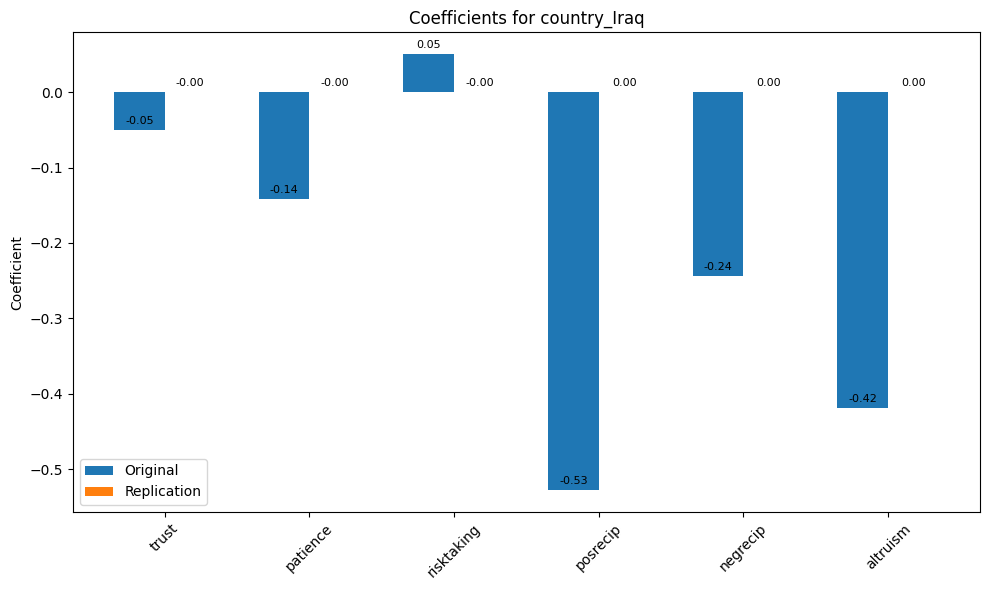

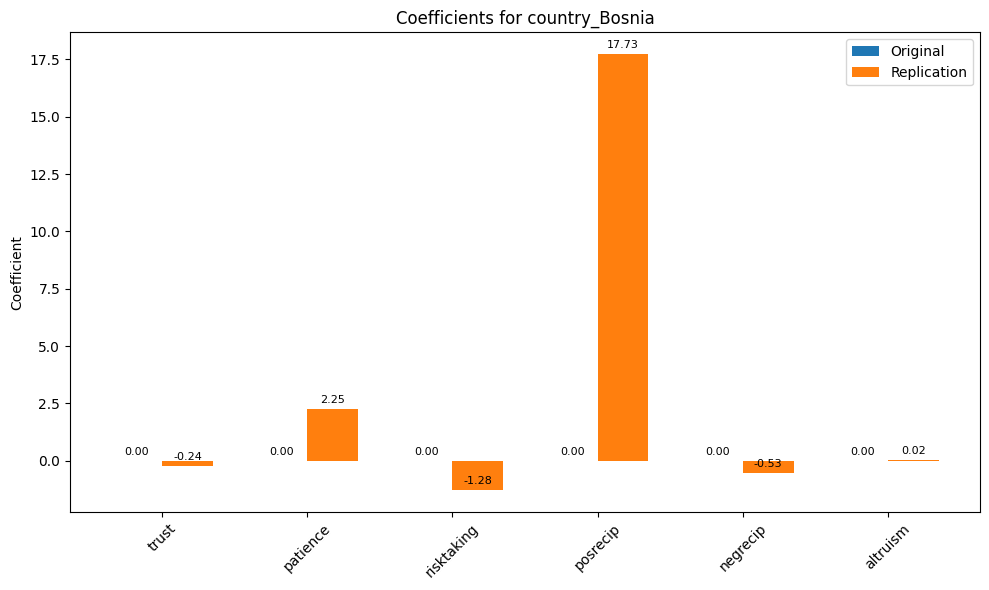

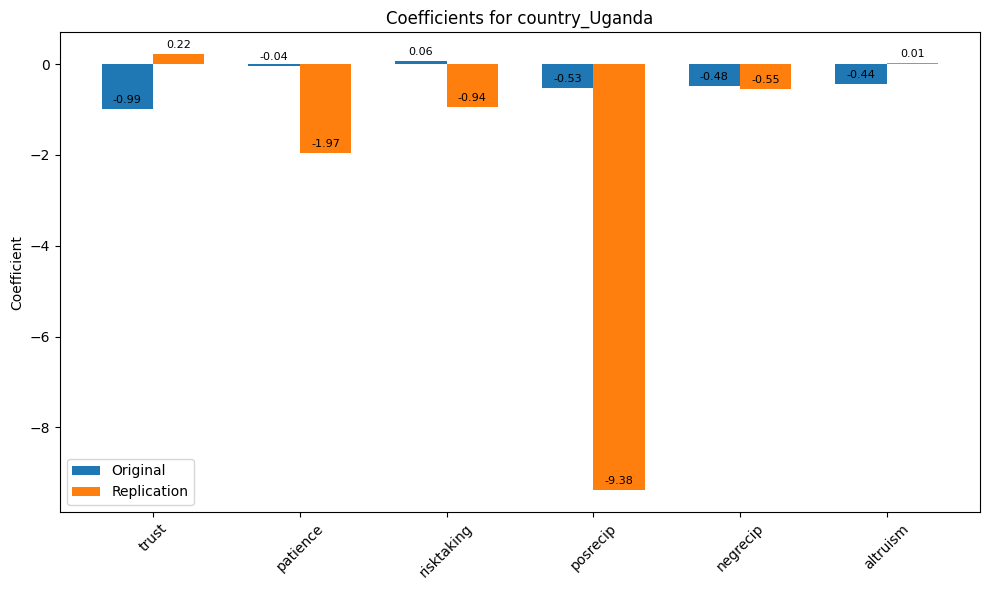

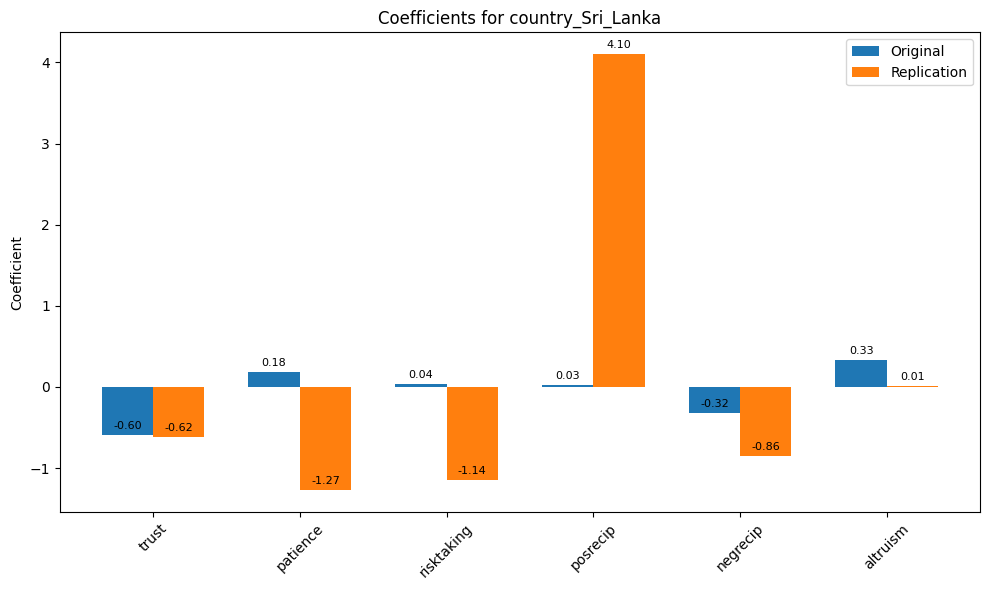

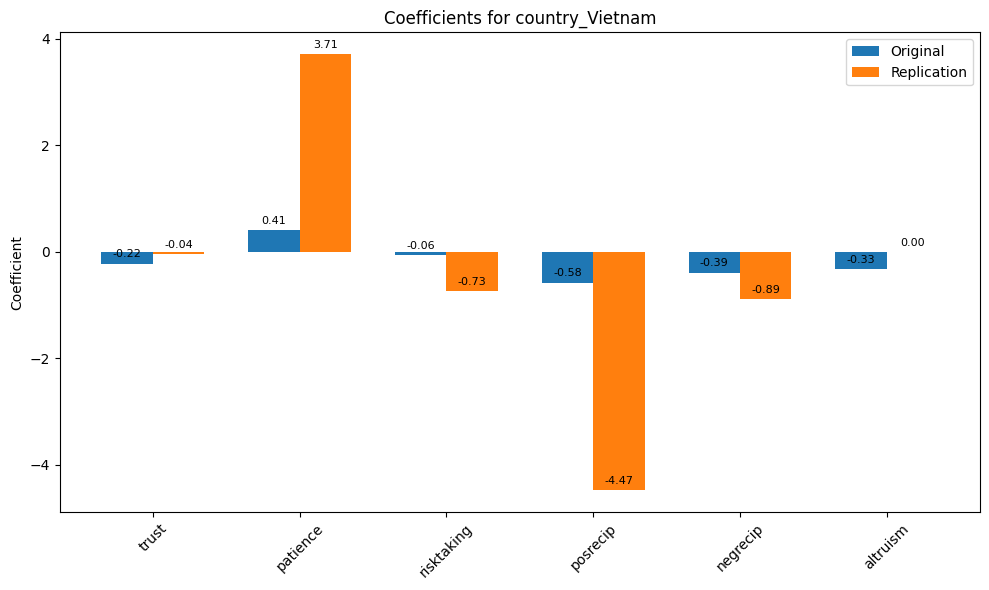

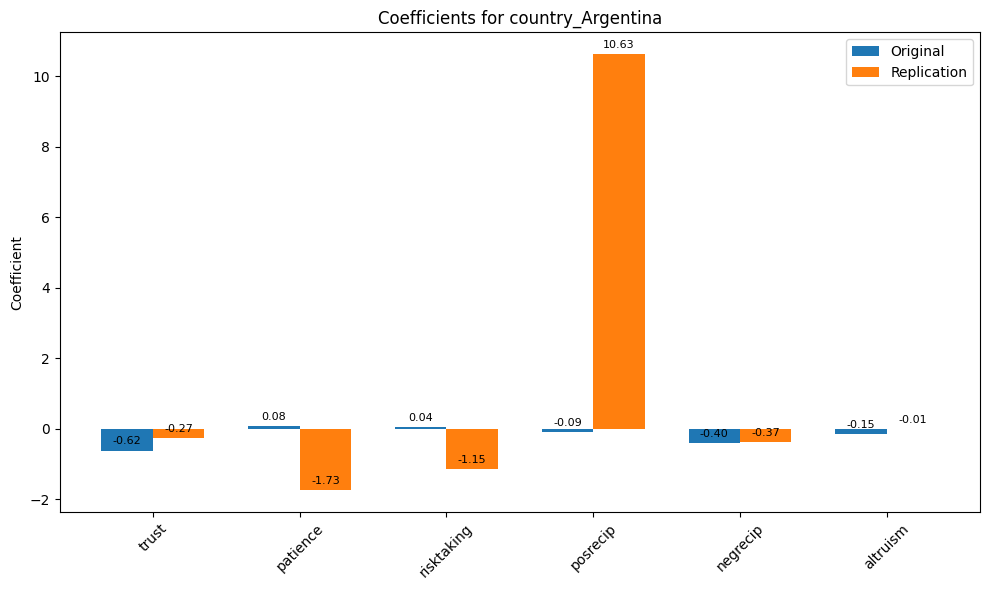

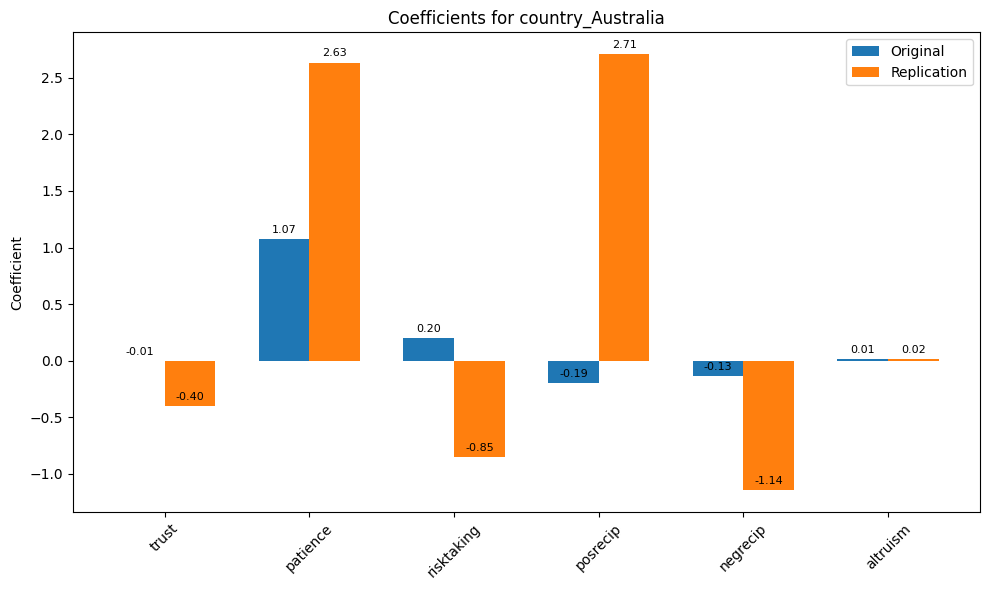

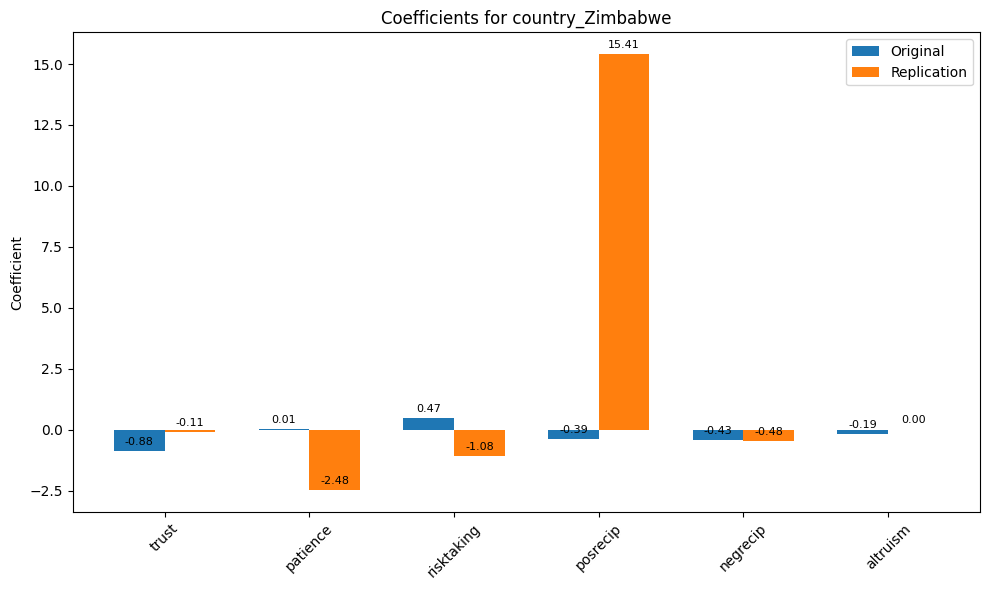

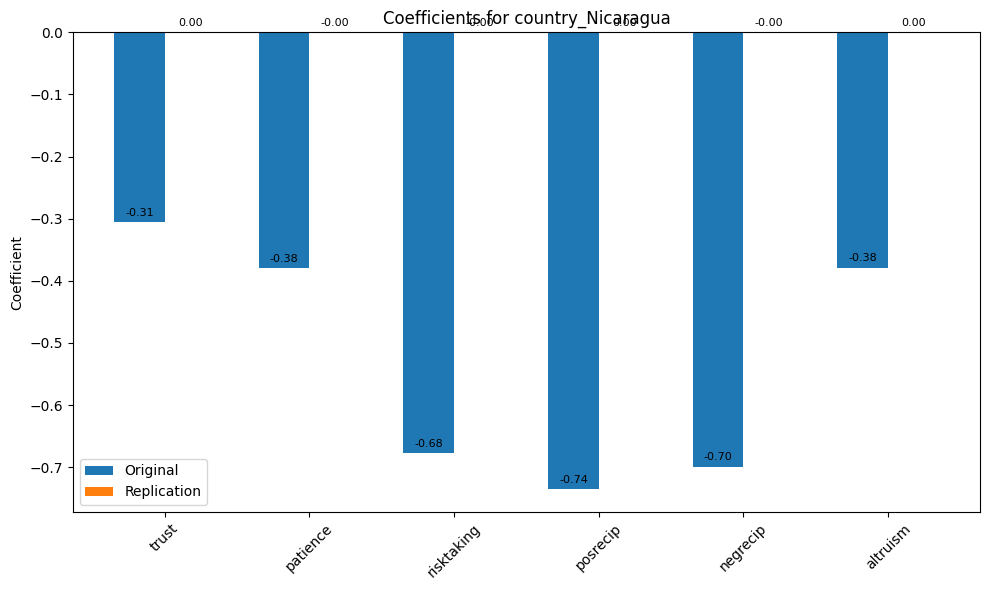

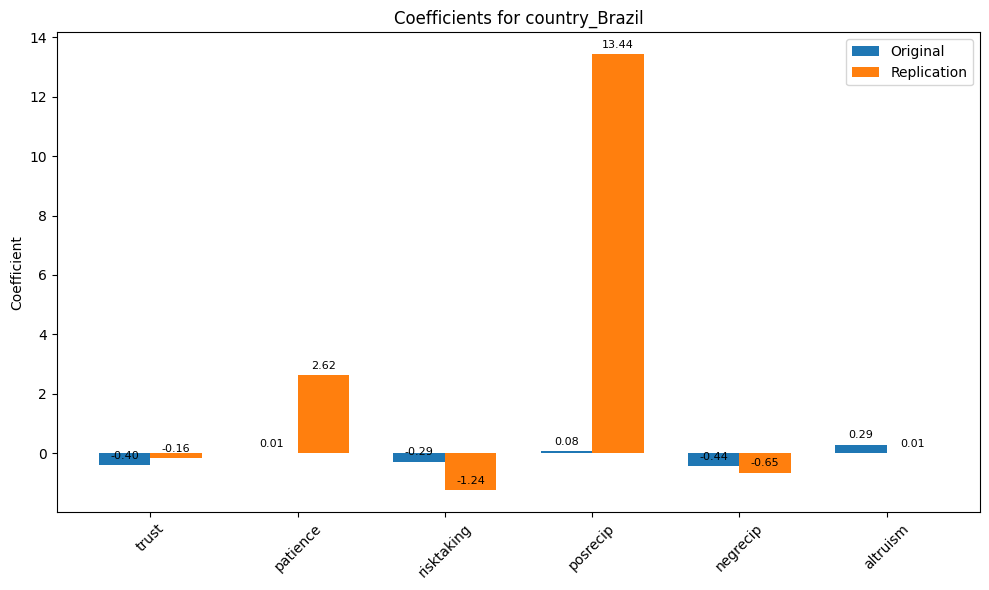

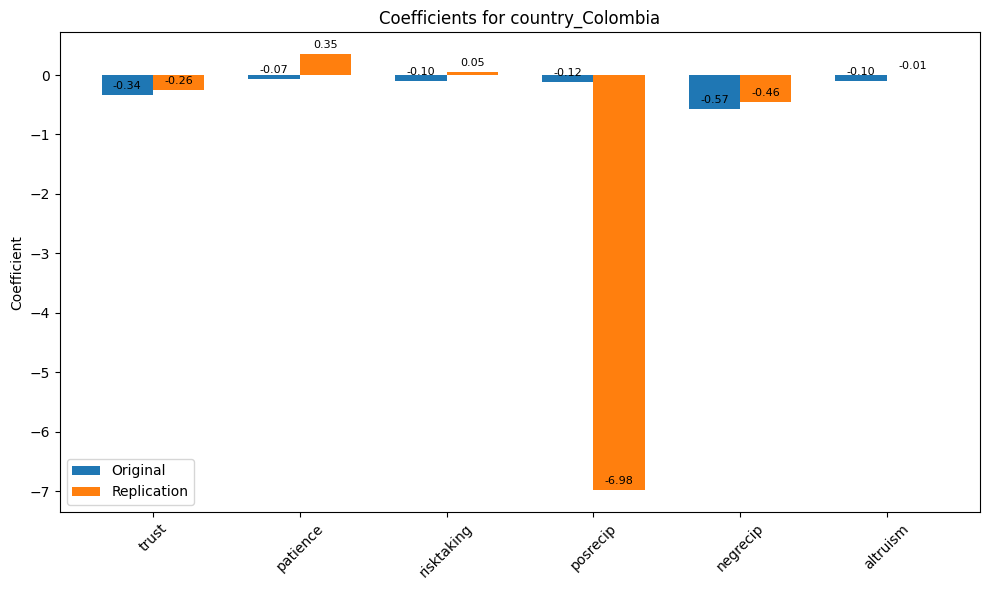

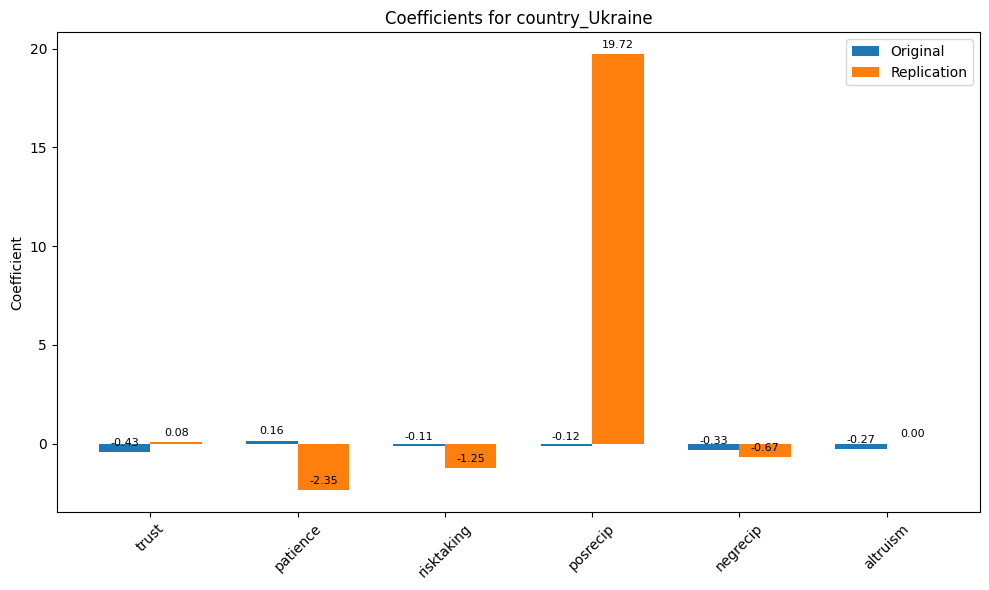

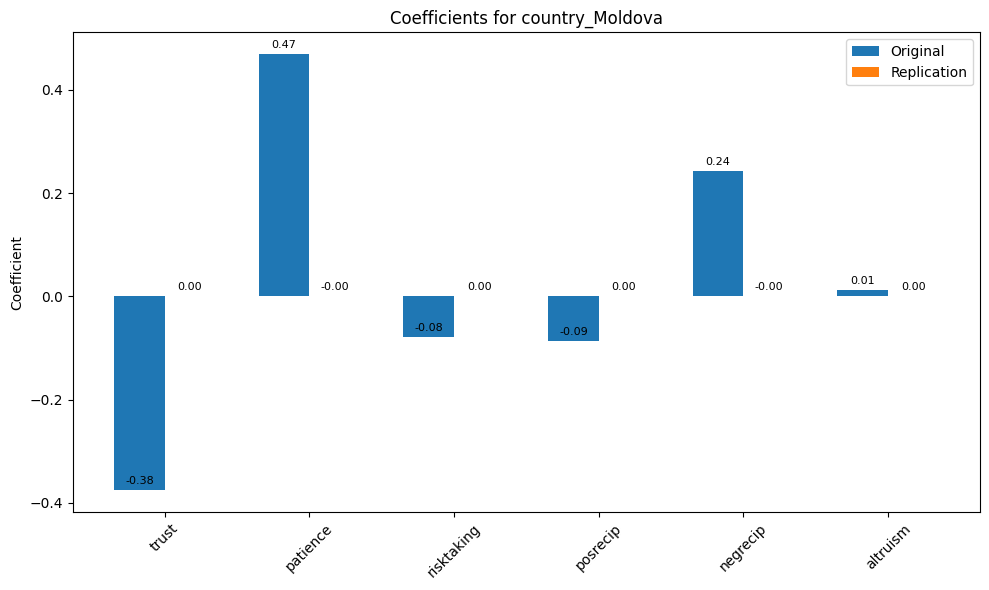

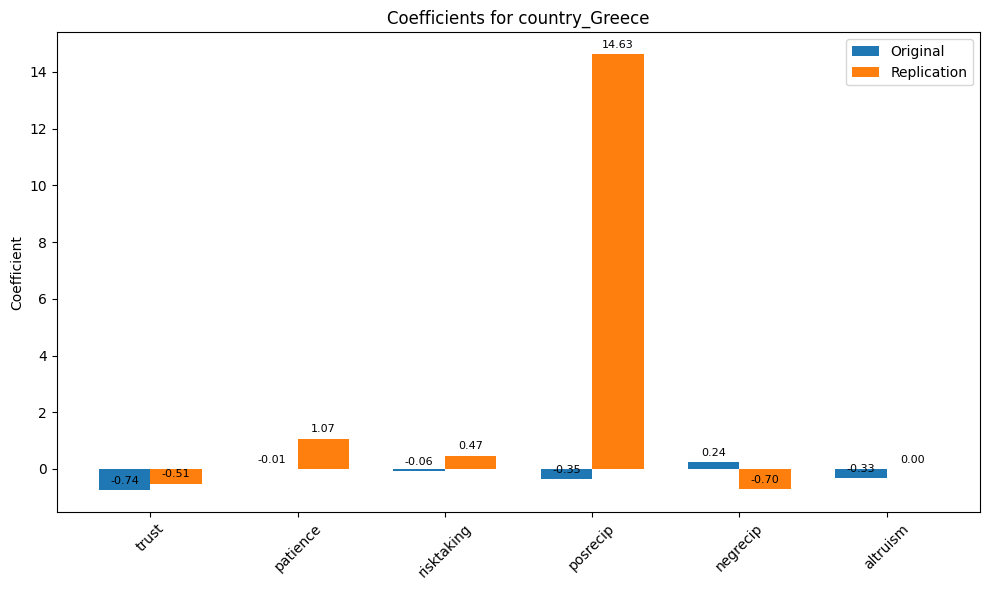

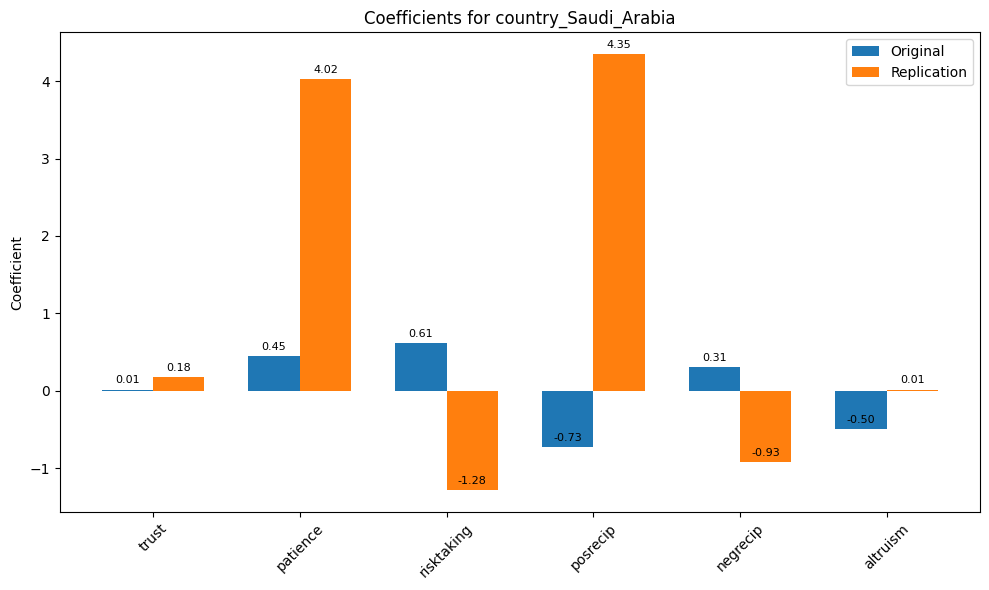

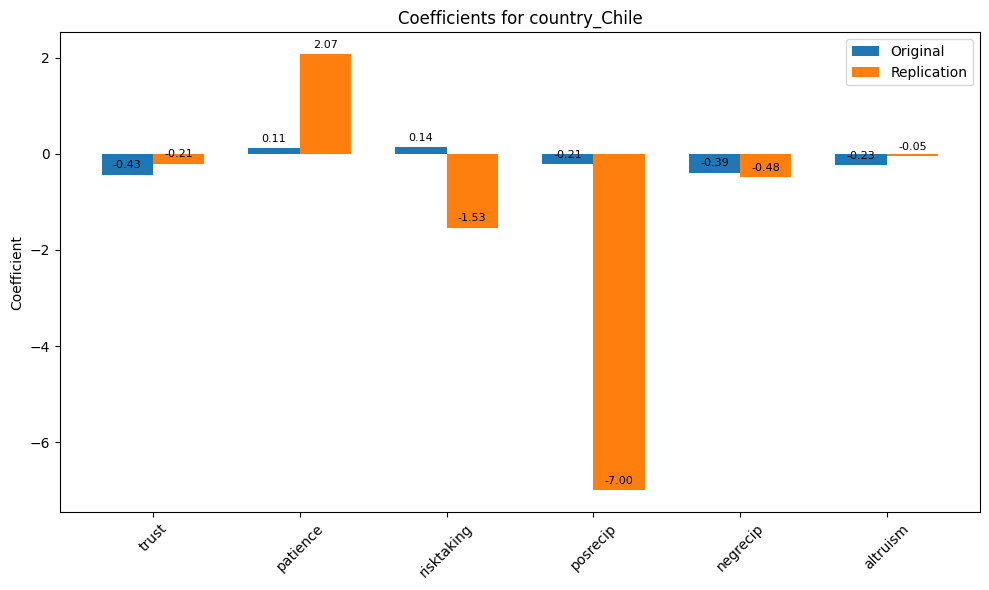

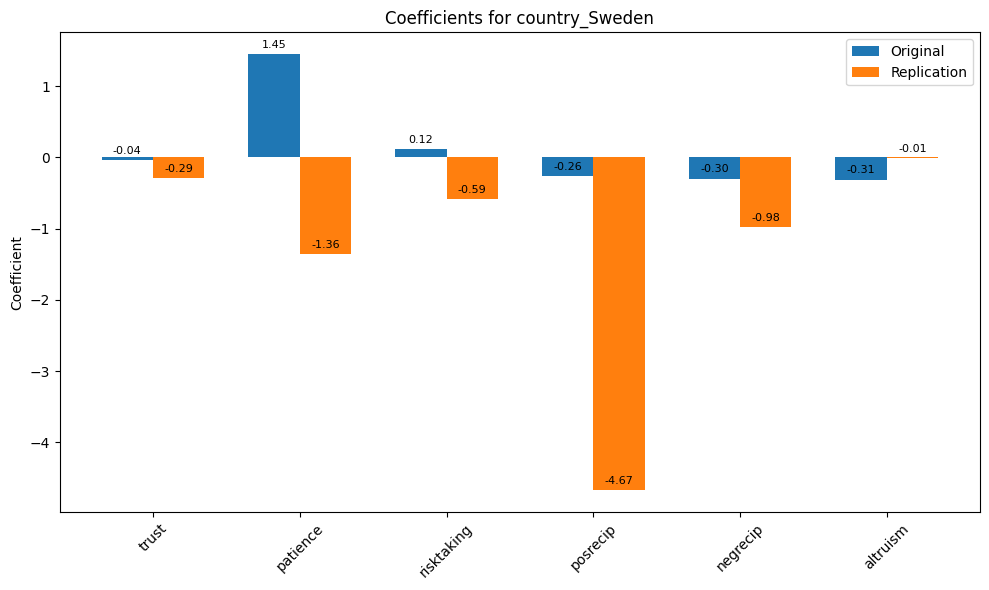

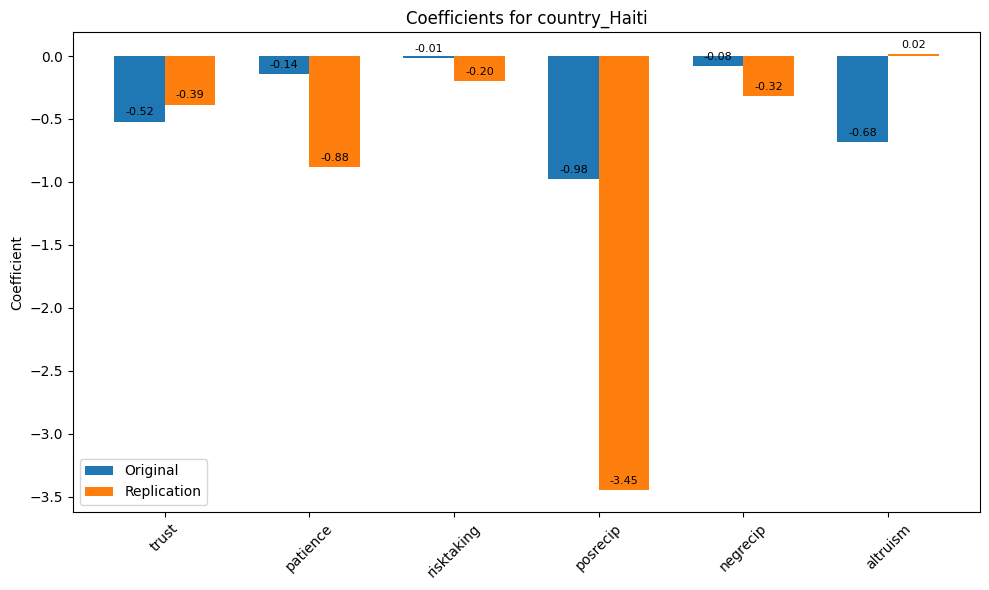

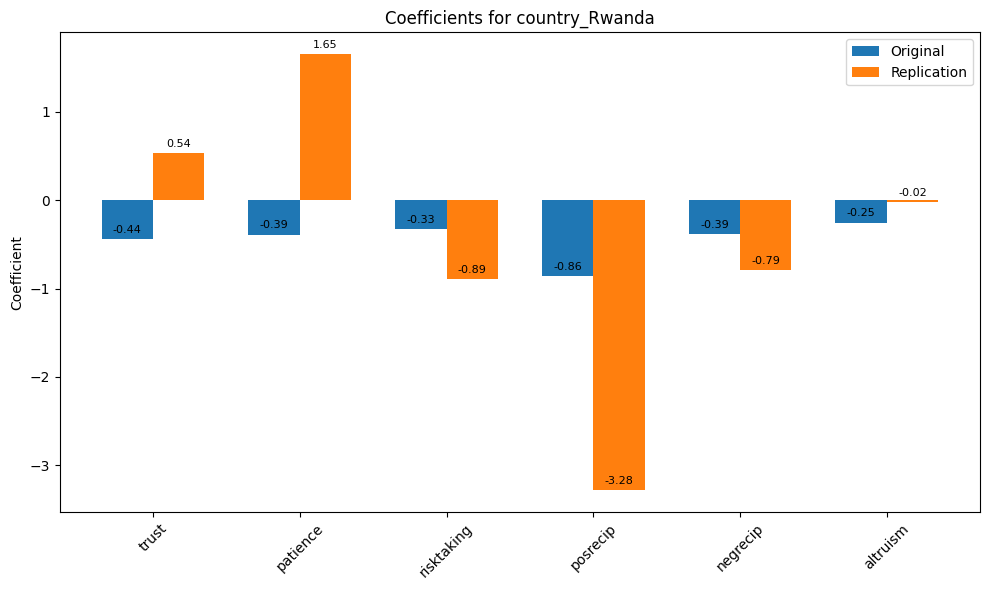

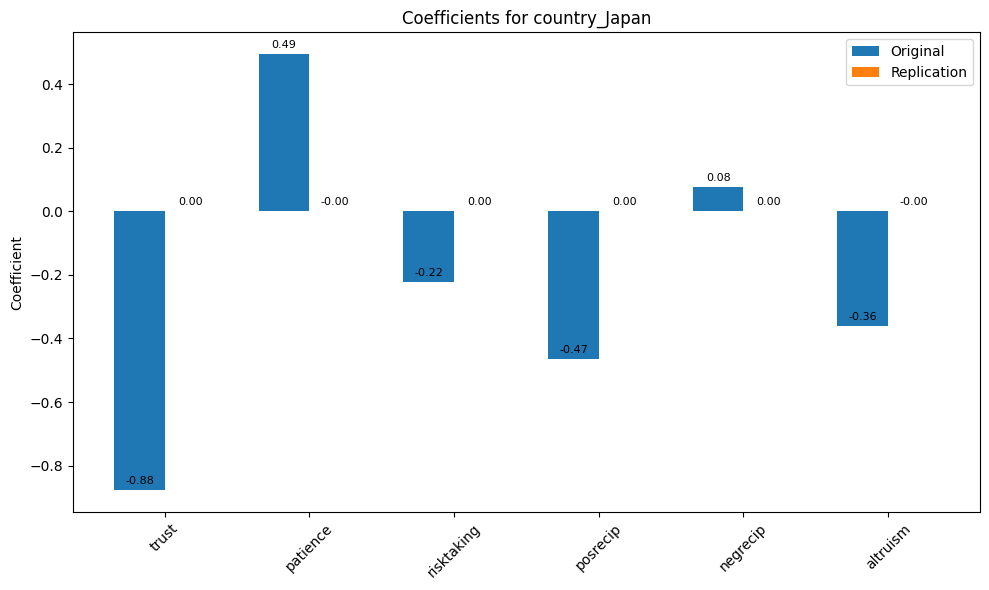

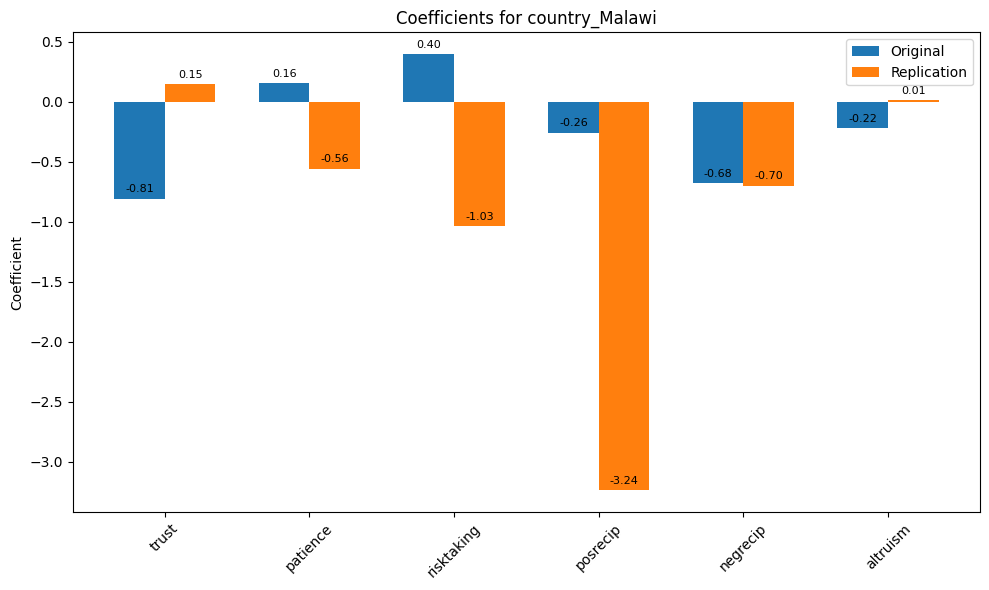

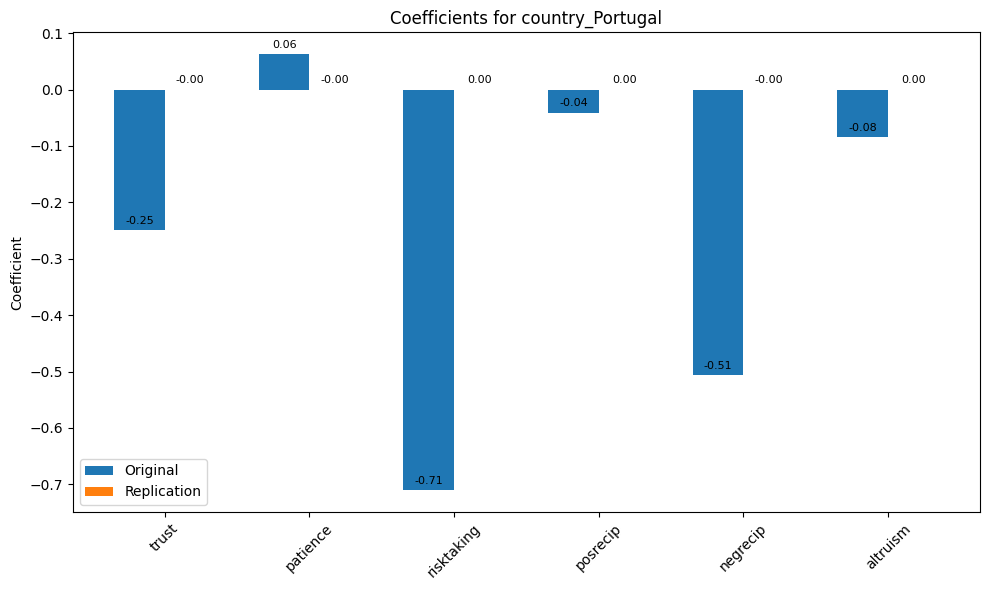

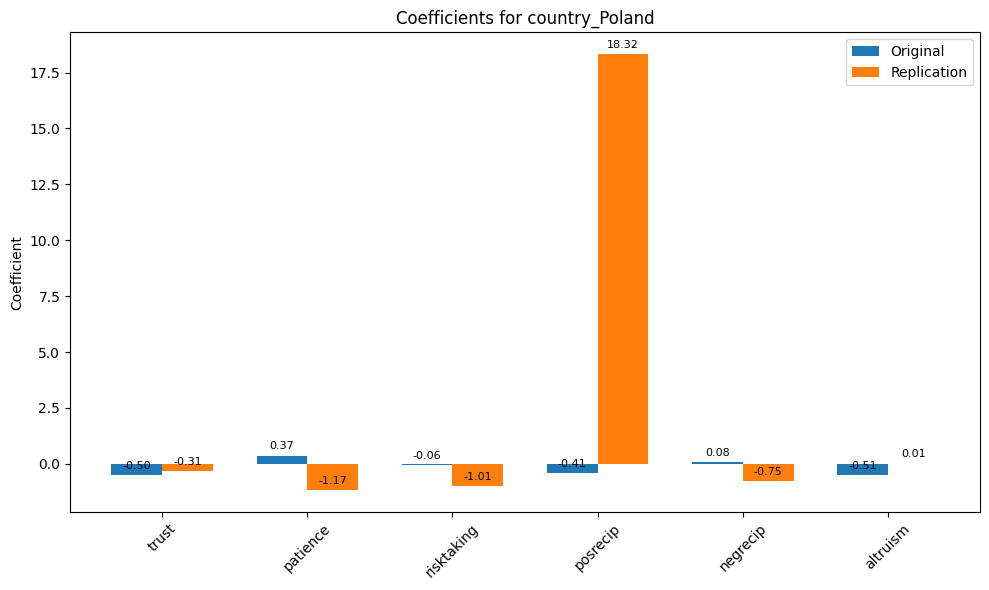

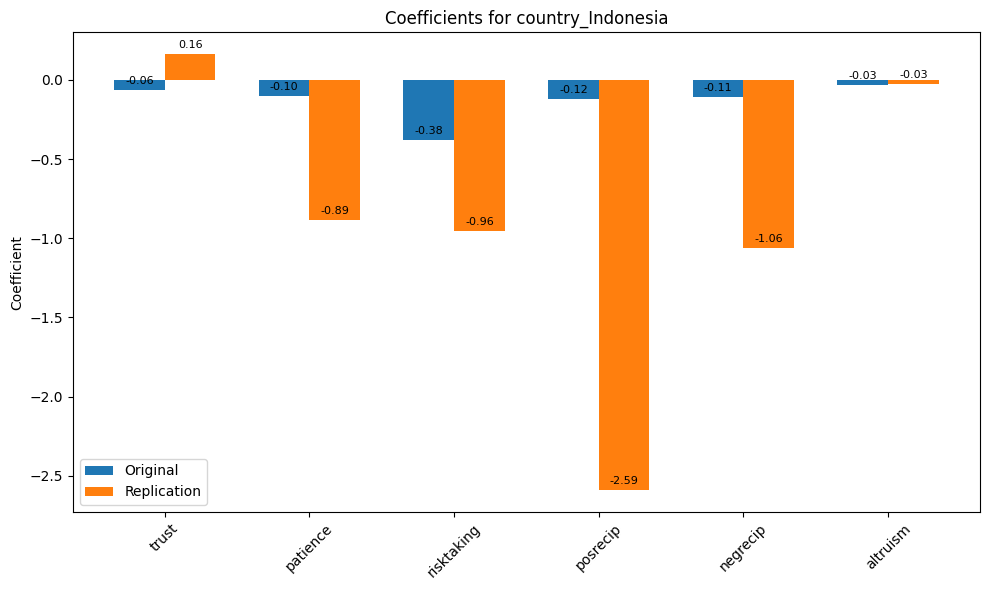

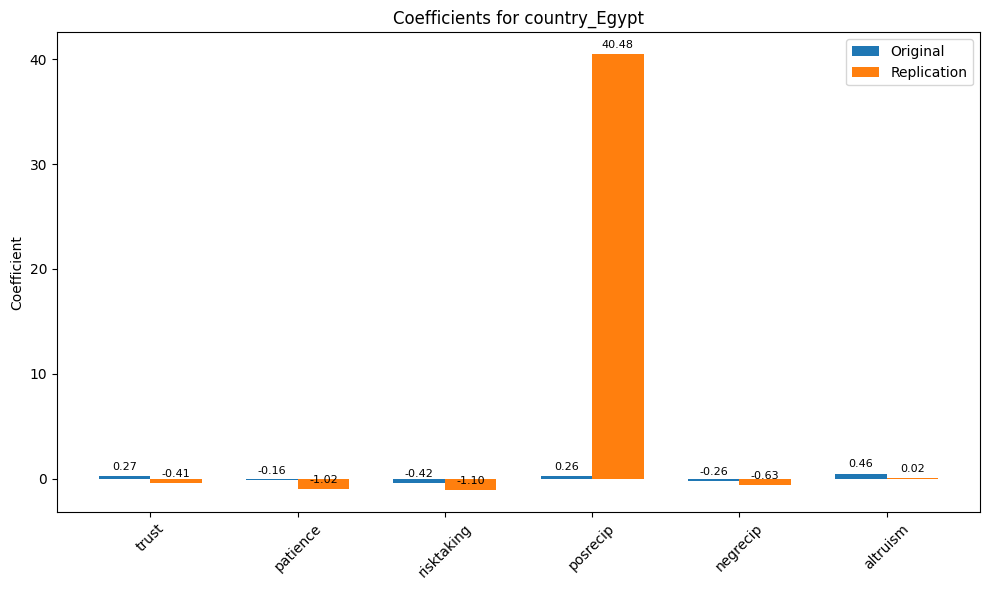

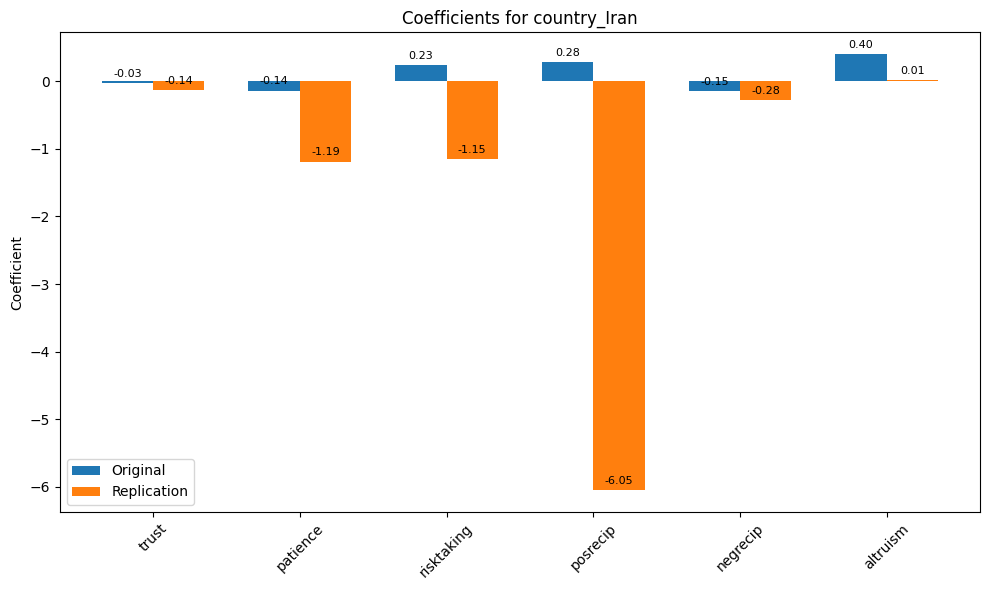

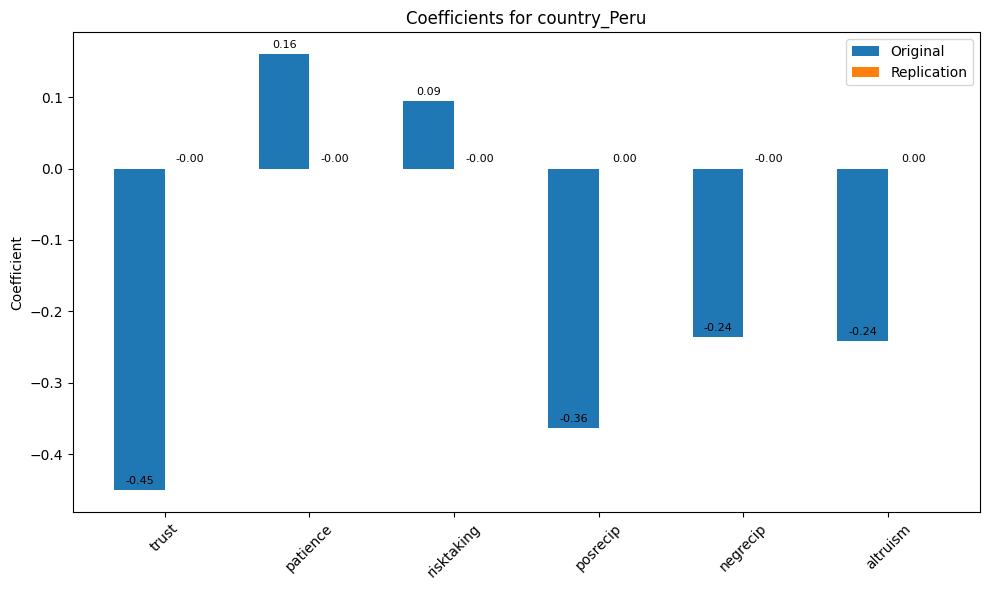

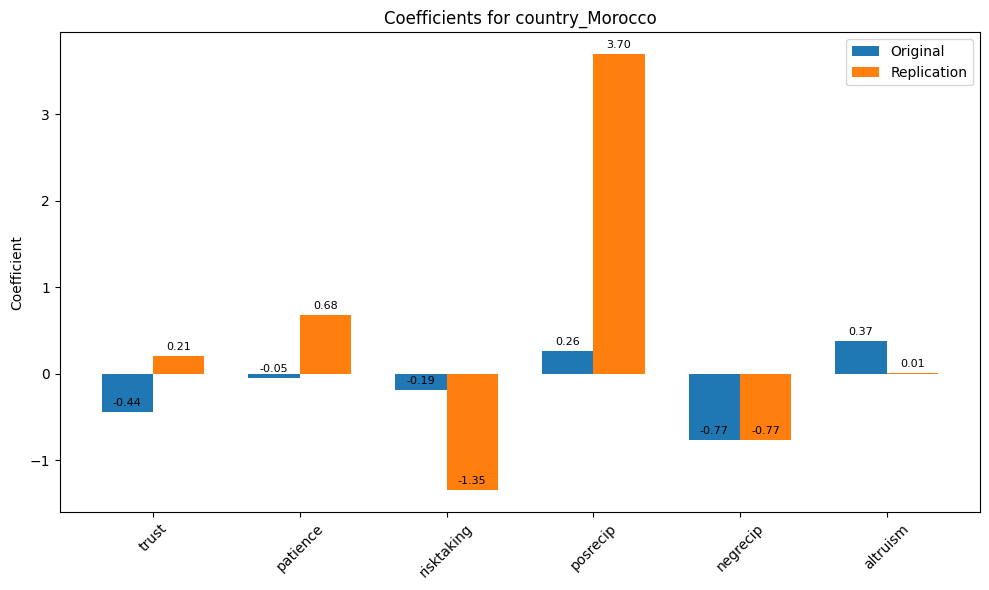

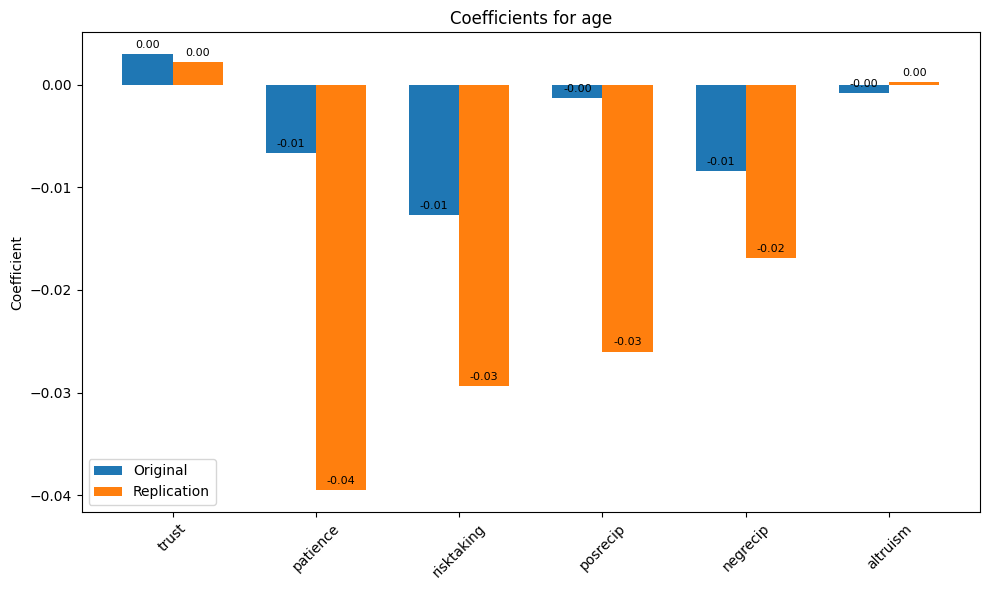

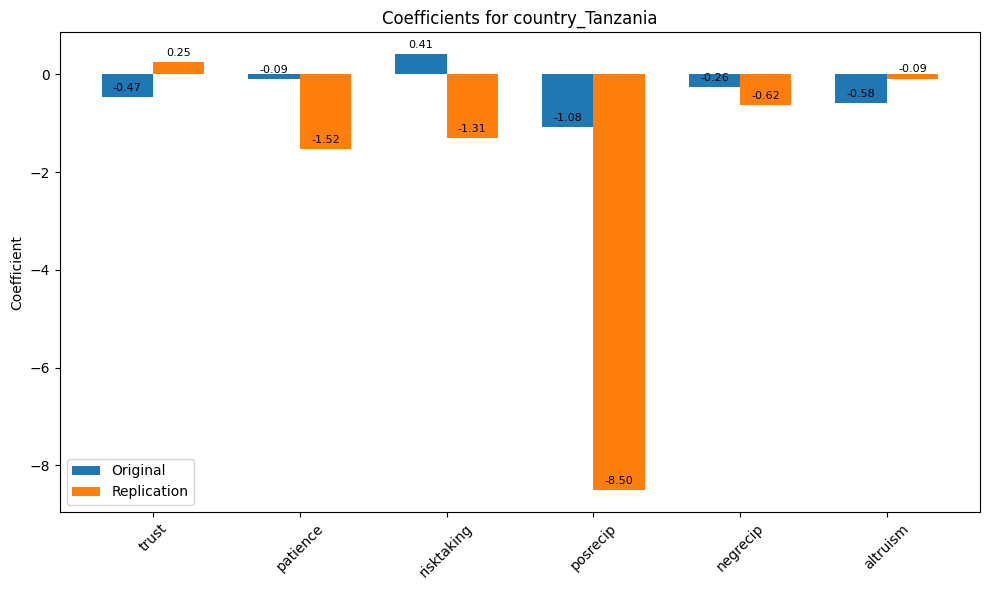

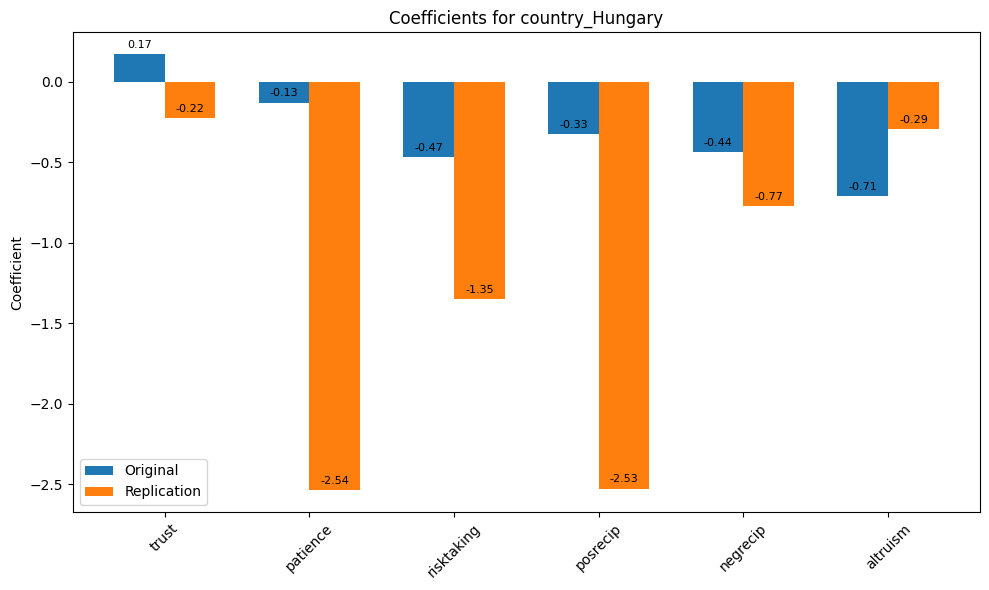

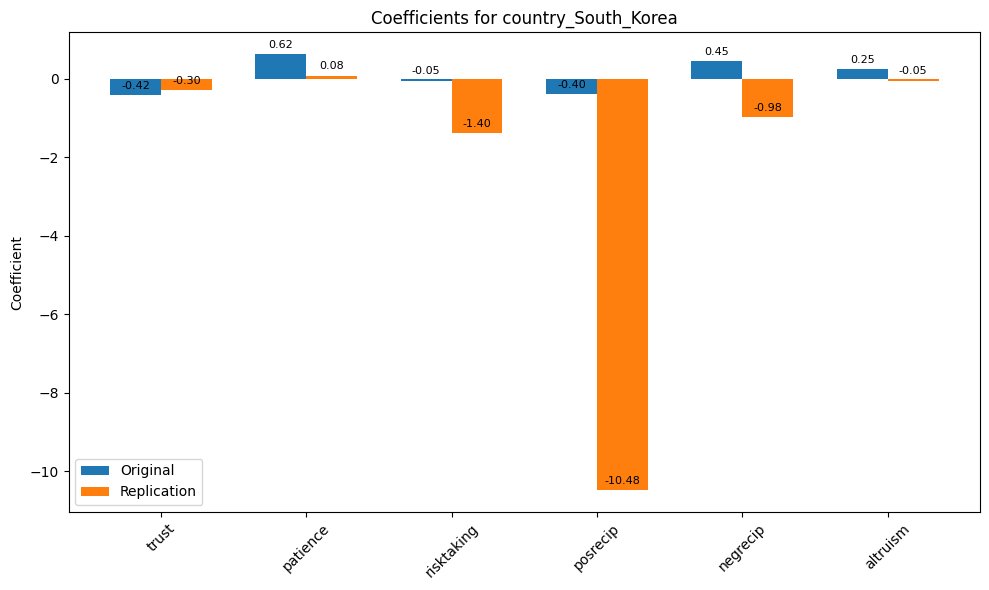

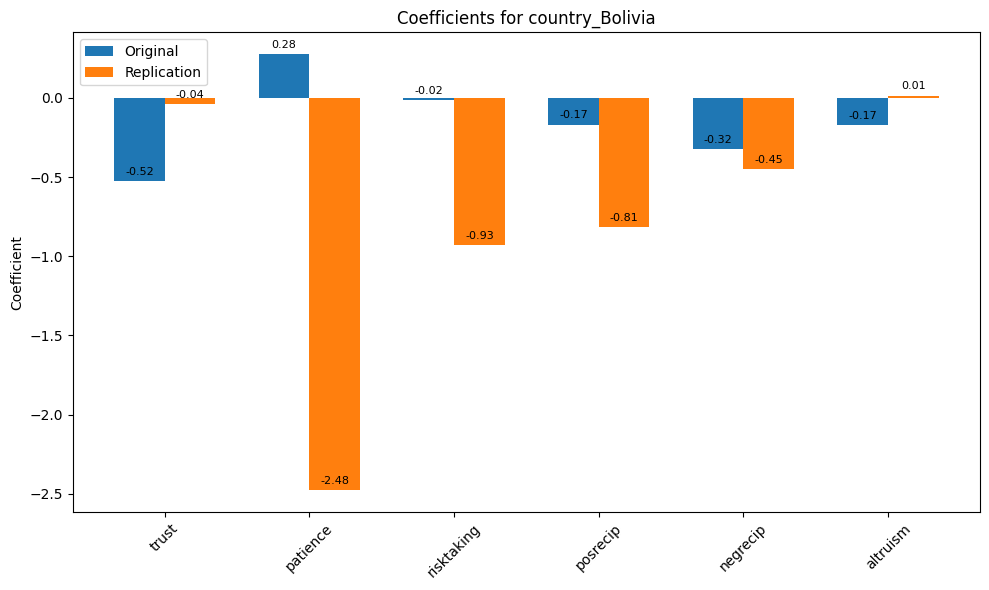

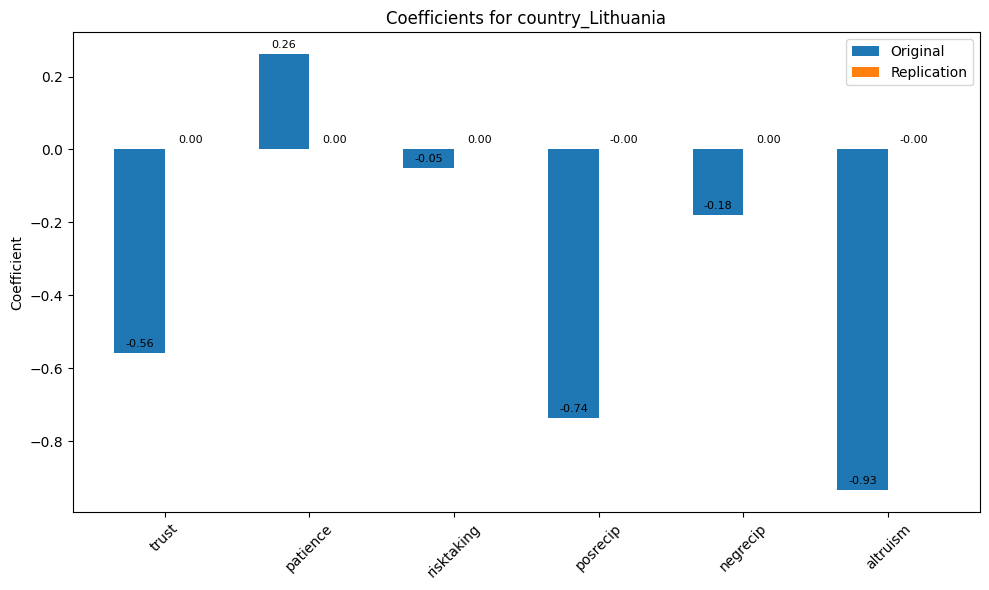

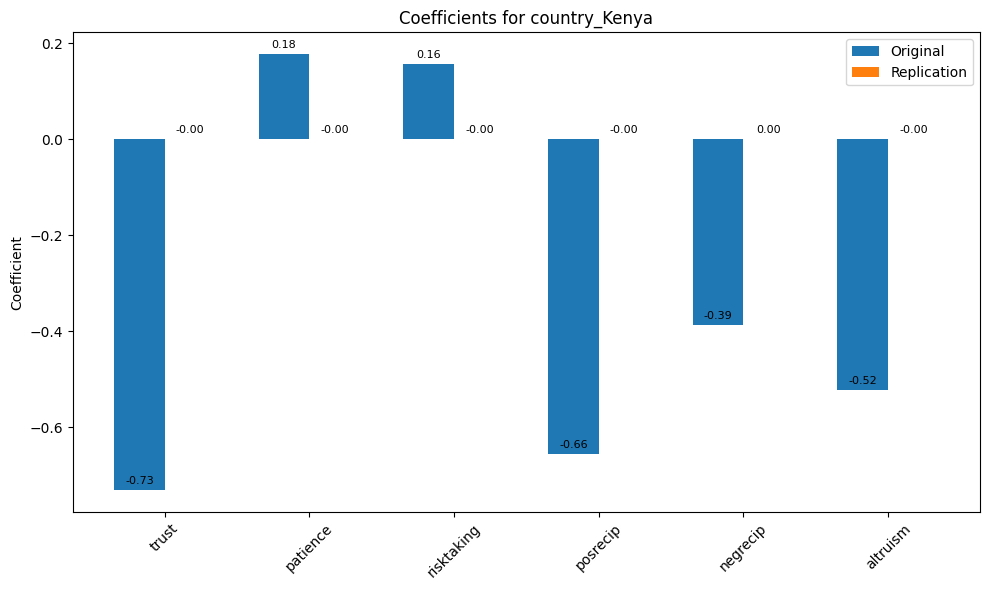

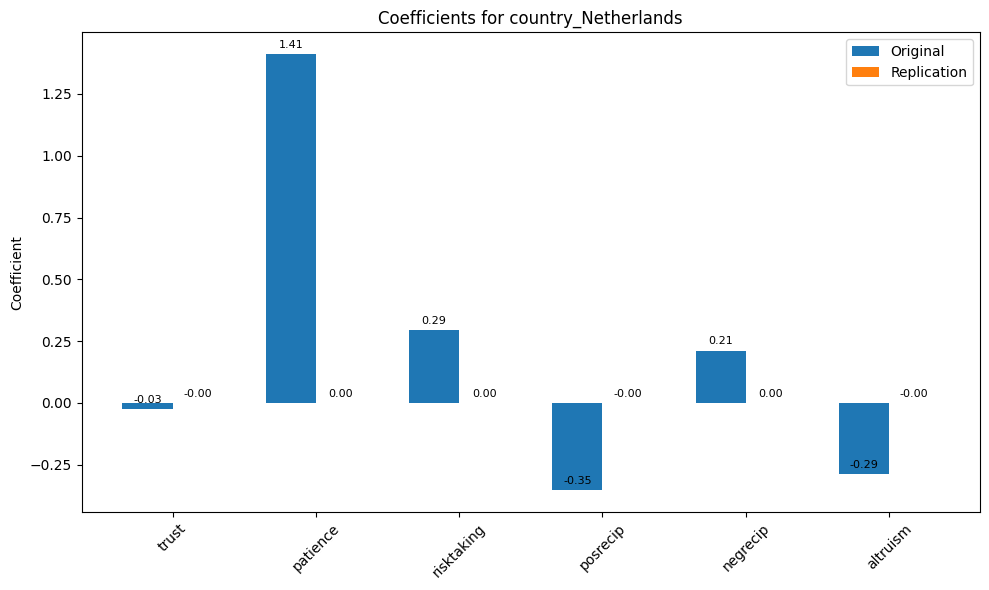

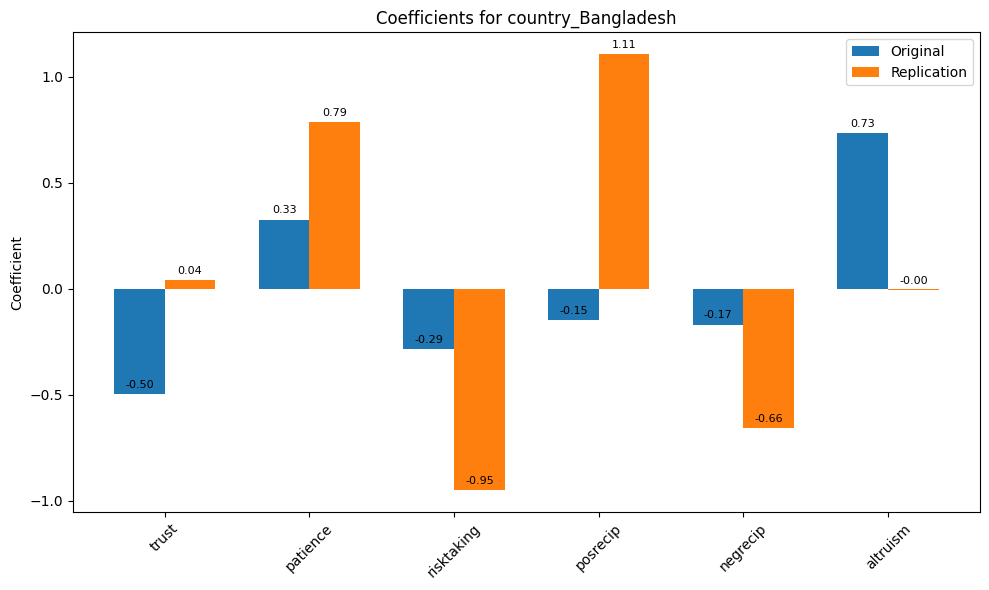

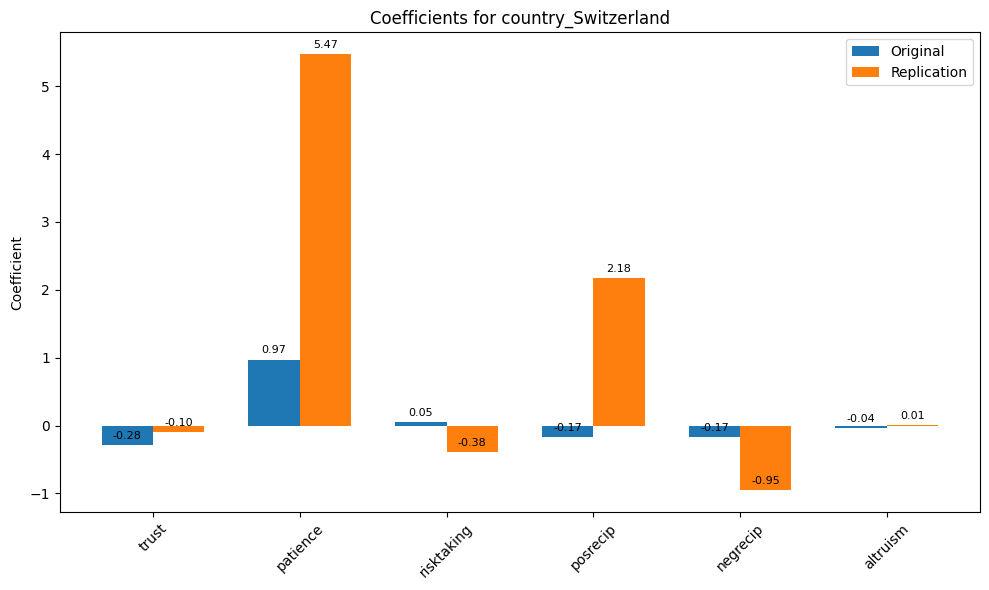

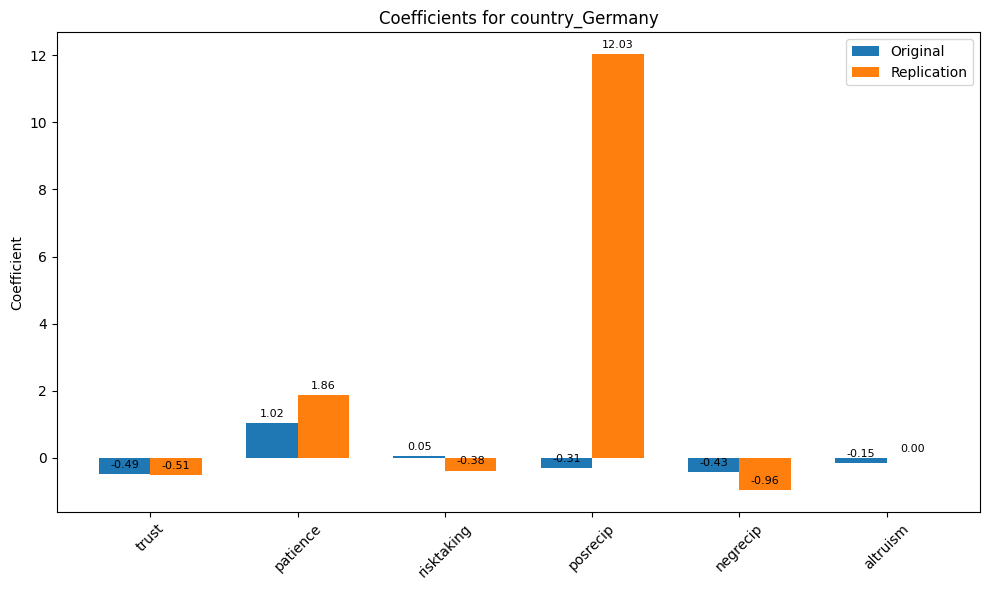

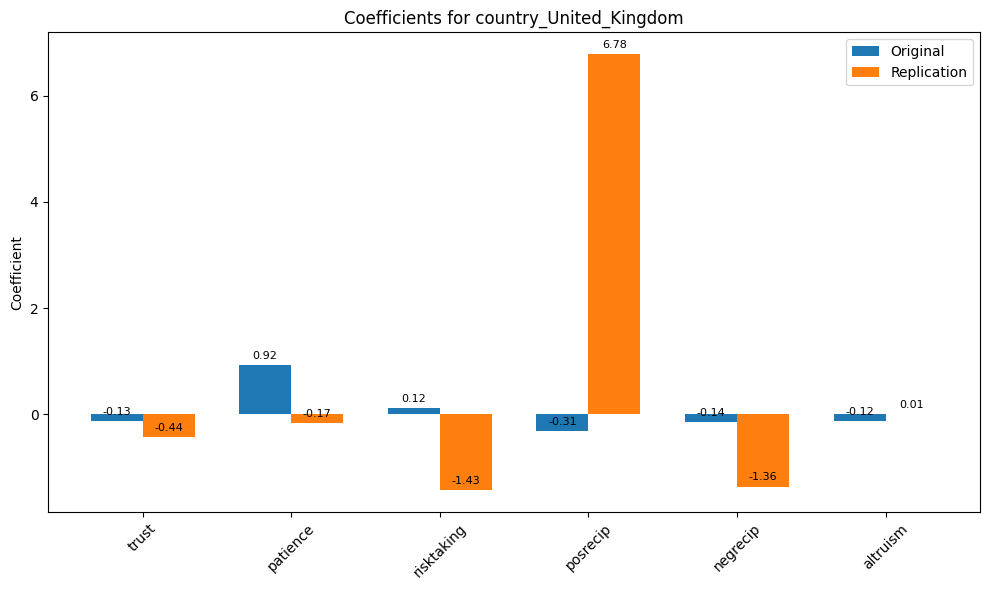

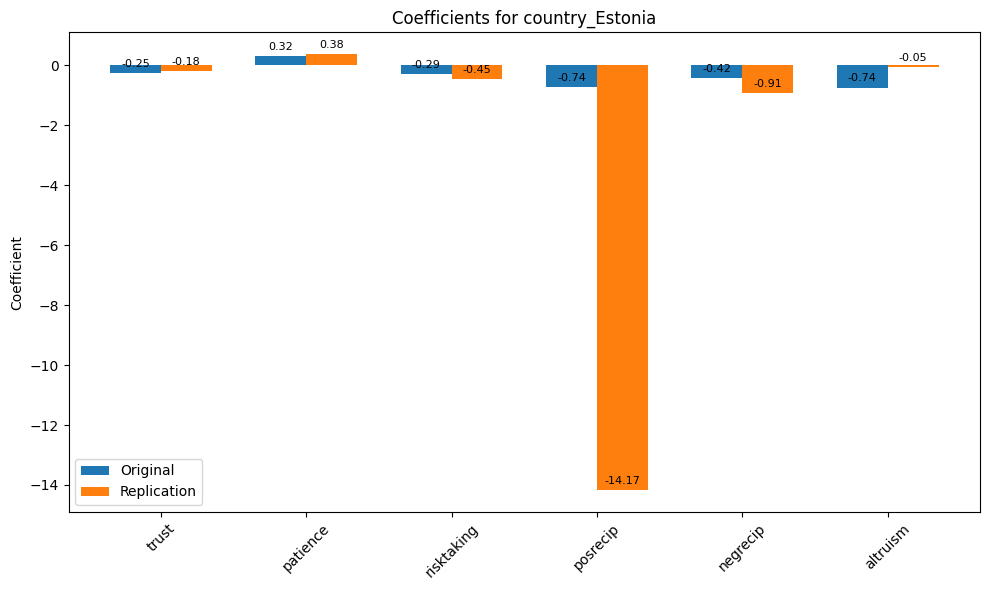

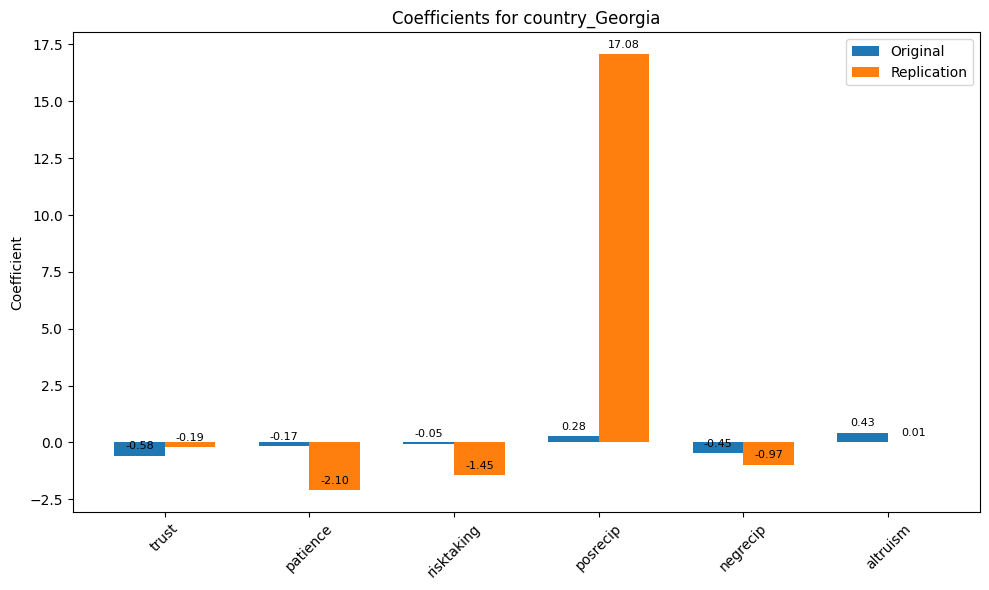

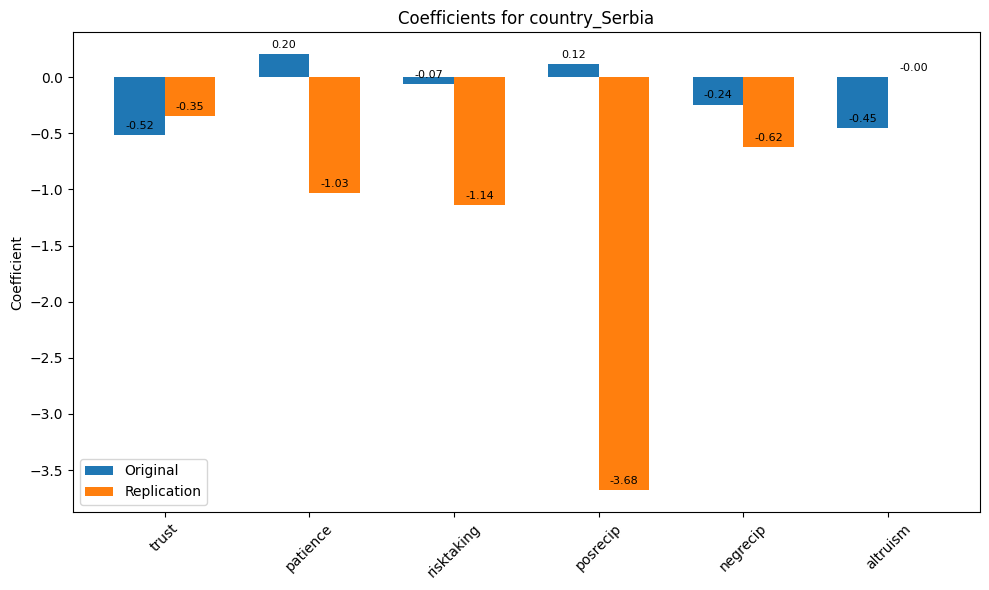

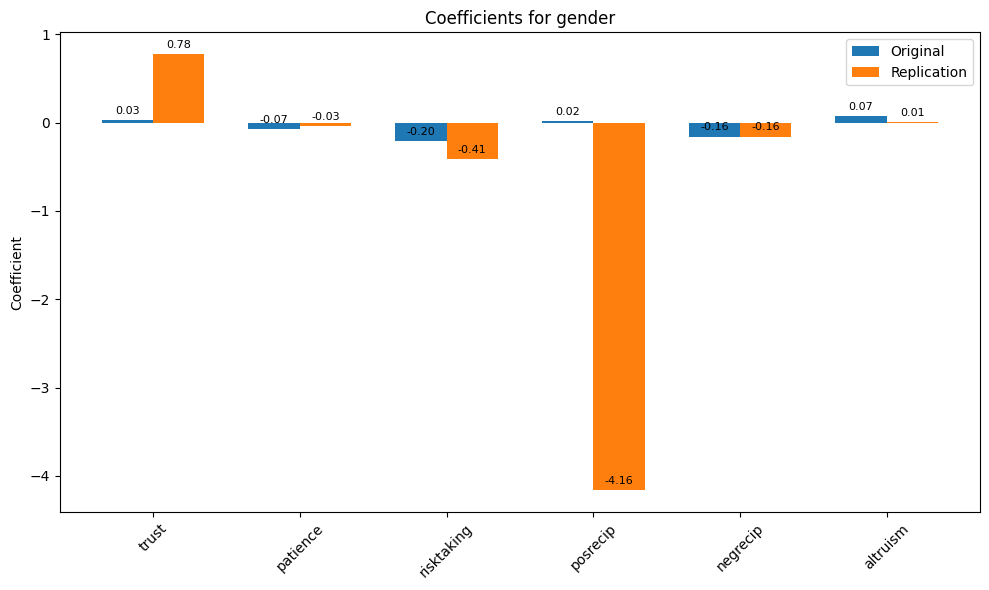

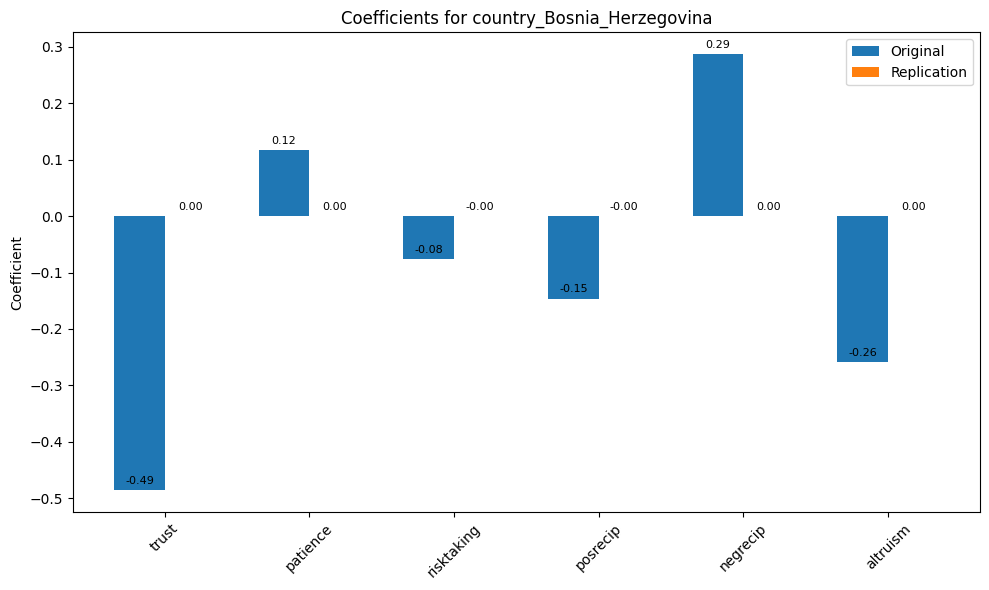

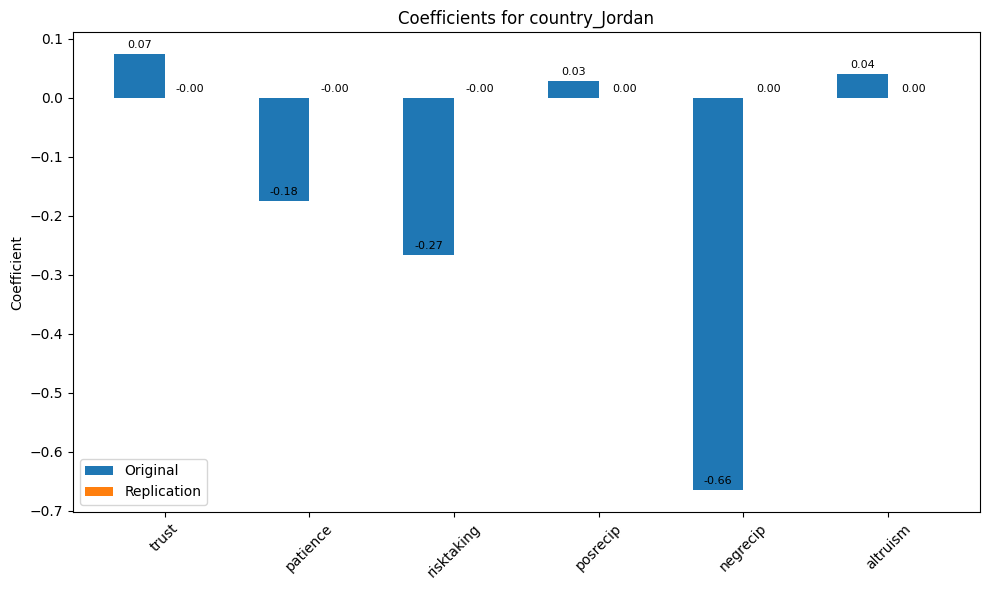

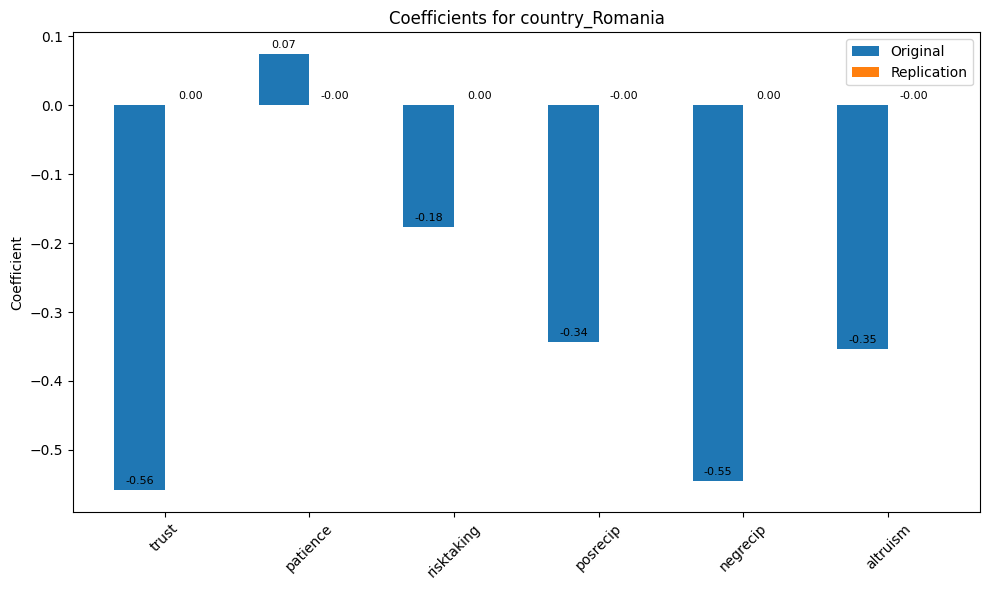

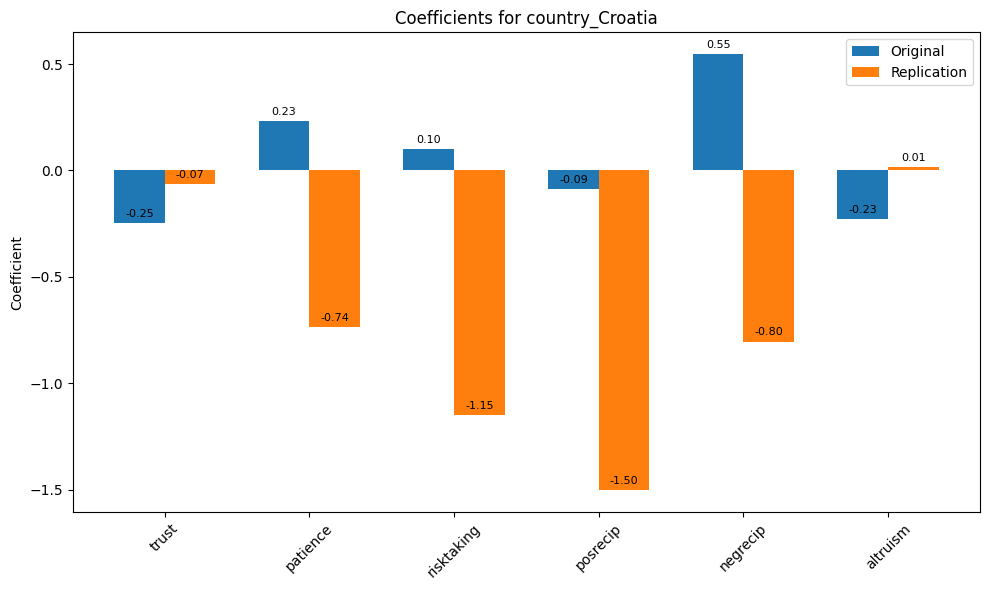

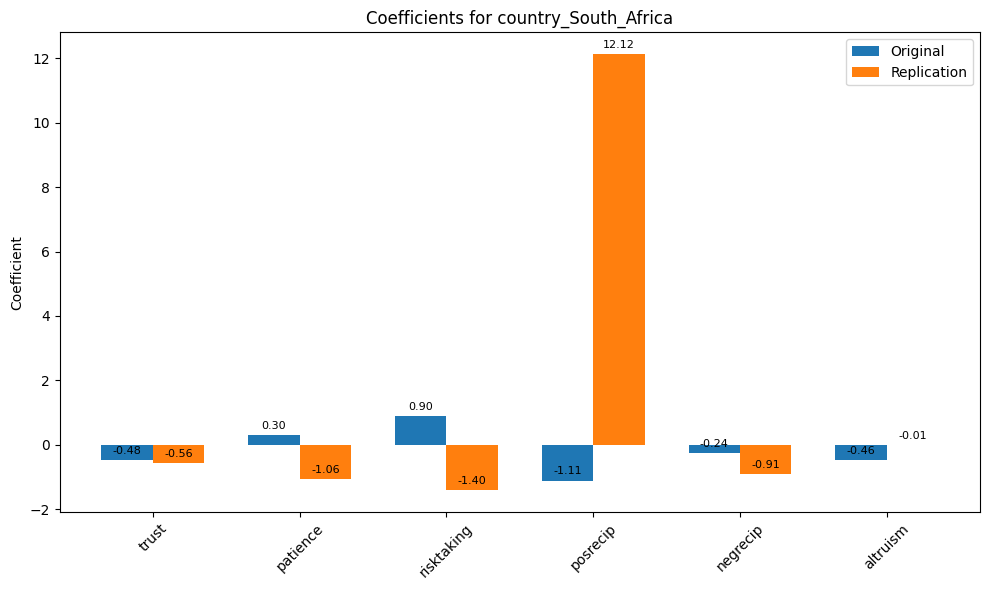

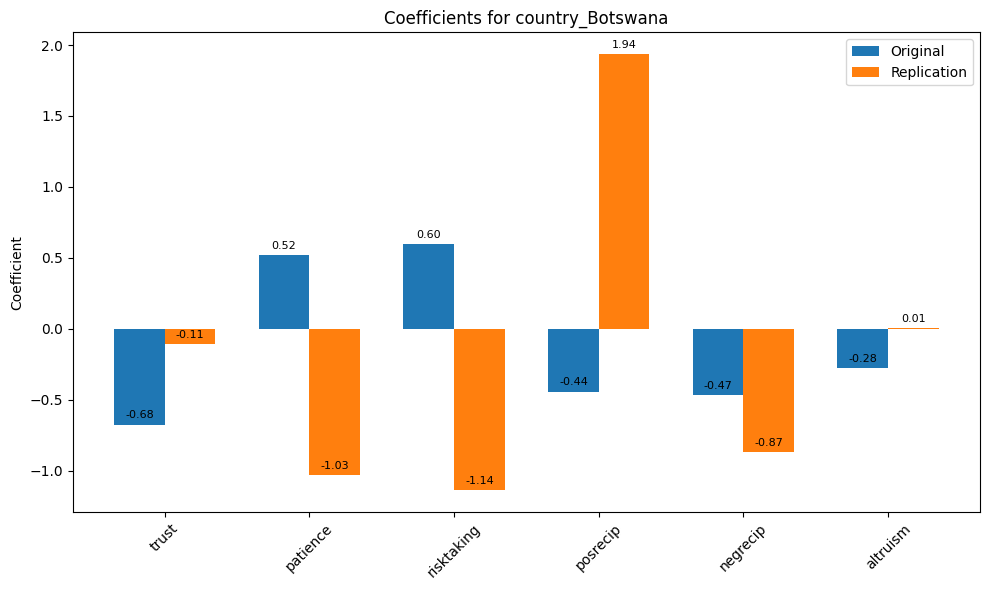

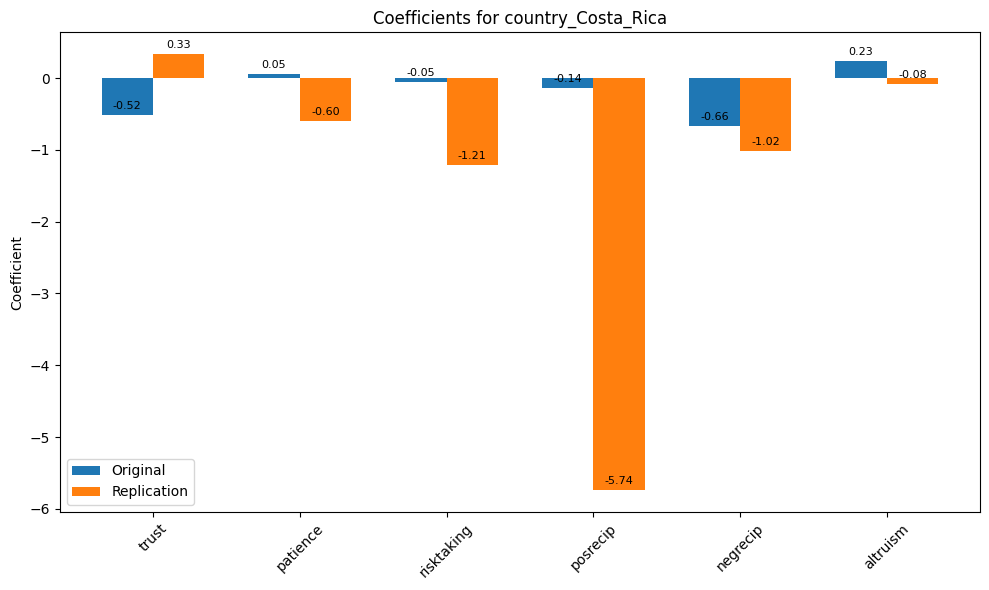

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Assuming 'df' is your DataFrame containing the data

# Step 1: Data Cleaning

# Check data types
print("Data types before conversion:")
print(df.dtypes)

# Convert columns to numeric where appropriate
# Exclude columns that are supposed to be categorical or strings
non_numeric_columns = ['participant_id']  # Add other non-numeric columns if any
numeric_columns = [col for col in df.columns if col not in non_numeric_columns]

# Convert columns to numeric, coerce errors to NaN
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Verify data types after conversion
print("\nData types after conversion:")
print(df.dtypes)

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Define variables of interest
demographic_vars = ['age', 'gender'] + [col for col in df.columns if col.startswith('country_')]
outcome_vars = ['trust', 'patience', 'risktaking', 'posrecip', 'negrecip', 'altruism']

# Step 2: Regression Analysis

# Initialize a dictionary to store results
results_summary = {}

for outcome_var in outcome_vars:
    print(f"\nAnalyzing outcome variable: {outcome_var}")
    
    # Check if outcome_var exists in the DataFrame
    if outcome_var not in df.columns:
        print(f"Warning: {outcome_var} not found in DataFrame. Skipping.")
        continue

    # Prepare data for original study (category_binary = 0)
    df_orig = df[df['category_binary'] == 0]
    df_orig_clean = df_orig.dropna(subset=demographic_vars + [outcome_var])

    # Prepare data for replication study (category_binary = 1)
    df_rep = df[df['category_binary'] == 1]
    df_rep_clean = df_rep.dropna(subset=demographic_vars + [outcome_var])

    # Ensure there is data to analyze
    if df_orig_clean.empty or df_rep_clean.empty:
        print(f"Warning: Not enough data for {outcome_var}. Skipping.")
        continue

    # Define independent variables (demographics)
    X_orig = df_orig_clean[demographic_vars]
    X_rep = df_rep_clean[demographic_vars]

    # Add constant term for intercept
    X_orig = sm.add_constant(X_orig)
    X_rep = sm.add_constant(X_rep)

    # Define dependent variable
    y_orig = df_orig_clean[outcome_var]
    y_rep = df_rep_clean[outcome_var]

    # Run regression for original study
    model_orig = sm.OLS(y_orig, X_orig).fit()

    # Run regression for replication study
    model_rep = sm.OLS(y_rep, X_rep).fit()

    # Collect coefficients and p-values
    coef_orig = model_orig.params
    pvalues_orig = model_orig.pvalues
    coef_rep = model_rep.params
    pvalues_rep = model_rep.pvalues

    # Combine results into a DataFrame for comparison
    results_df = pd.DataFrame({
        'Coefficient (Original)': coef_orig,
        'p-value (Original)': pvalues_orig,
        'Coefficient (Replication)': coef_rep,
        'p-value (Replication)': pvalues_rep
    })

    # Determine if the sign and significance match
    results_df['Sign Match'] = np.sign(results_df['Coefficient (Original)']) == np.sign(results_df['Coefficient (Replication)'])
    results_df['Significant (Original)'] = results_df['p-value (Original)'] < 0.05
    results_df['Significant (Replication)'] = results_df['p-value (Replication)'] < 0.05
    results_df['Significance Match'] = results_df['Significant (Original)'] == results_df['Significant (Replication)']

    # Store results
    results_summary[outcome_var] = results_df

# Step 3: Display Results

for outcome_var, results_df in results_summary.items():
    print(f"\n=== Results for {outcome_var} ===")
    print(results_df)

# Step 4: Visualization

import matplotlib.pyplot as plt

# Extract all unique variables from the results
variables_set = set()
for outcome_var, results_df in results_summary.items():
    variables_set.update(results_df.index.tolist())
variables = list(variables_set)

# Remove 'const' from variables as we don't typically plot intercepts
variables = [var for var in variables if var != 'const']

# For each variable, create a bar plot
for var in variables:
    # Create a list to store coefficients for each outcome variable
    coeffs_list = []
    for outcome_var in outcome_vars:
        # Initialize coefficients as NaN
        coeff_orig = np.nan
        coeff_rep = np.nan
        if outcome_var in results_summary:
            results_df = results_summary[outcome_var]
            if var in results_df.index:
                coeff_orig = results_df.loc[var, 'Coefficient (Original)']
                coeff_rep = results_df.loc[var, 'Coefficient (Replication)']
        coeffs_list.append({
            'Outcome Variable': outcome_var,
            'Coefficient (Original)': coeff_orig,
            'Coefficient (Replication)': coeff_rep
        })
    # Convert the list to a DataFrame
    coeffs_df = pd.DataFrame(coeffs_list)
    # Remove rows where both coefficients are NaN
    coeffs_df = coeffs_df.dropna(subset=['Coefficient (Original)', 'Coefficient (Replication)'], how='all')

    # Proceed to plot if coeffs_df is not empty
    if not coeffs_df.empty:
        x = np.arange(len(coeffs_df['Outcome Variable']))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot only available coefficients
        coeff_orig_vals = coeffs_df['Coefficient (Original)'].values
        coeff_rep_vals = coeffs_df['Coefficient (Replication)'].values

        rects1 = ax.bar(x - width/2, coeff_orig_vals, width, label='Original')
        rects2 = ax.bar(x + width/2, coeff_rep_vals, width, label='Replication')

        # Add labels, title, and custom x-axis tick labels
        ax.set_ylabel('Coefficient')
        ax.set_title(f'Coefficients for {var}')
        ax.set_xticks(x)
        ax.set_xticklabels(coeffs_df['Outcome Variable'])
        ax.legend()

        # Annotate bars with coefficient values
        for rect in rects1 + rects2:
            height = rect.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)

        # Rotate x-axis labels if they are too long
        plt.xticks(rotation=45)

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for variable '{var}'.")

In [14]:
# Step 5: Larger Correlation Matrix with More Space

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure categorical variables are encoded numerically
df_encoded = df.copy()

# List of categorical variables to encode
categorical_vars = ['gender'] + [col for col in df.columns if col.startswith('country_')]

for var in categorical_vars:
    if var in df.columns and df[var].dtype == 'object':
        df_encoded[var] = df[var].astype('category').cat.codes

# Select only numeric variables
numeric_vars = df_encoded.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_vars.corr()

# Increase figure size to give more space
plt.figure(figsize=(200, 180))  # Adjusted for more space
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, annot_kws={"size": 10})  # Adjust text size
plt.title('Correlation Matrix of All Variables', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()